<a href="https://colab.research.google.com/github/Skquark/structured-prompt-generator/blob/main/Enhanced_Stable_Diffusion_with_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Enhanced Stable Diffusion** 👨‍🎨️ 
*...using `🧨diffusers`* and practical bonus features...

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and runs on a GPU with at least 10GB VRAM.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

This Colab notebook uses Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers) or the original [Diffusers Notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb) 

---
### Mods and Flow Enhancements by [**Skquark**, Inc.](https://www.Skquark.com) 😋
<p align=center>
<a href="https://github.com/Skquark/structured-prompt-generator/blob/main/Enhanced_Stable_Diffusion_with_diffusers.ipynb"><img src="https://badgen.net/badge/icon/github?icon=github&label" alt="Github"></a> <a href="https://github.com/Skquark/structured-prompt-generator"><img src="https://badgen.net/github/release/Skquark/structured-prompt-generator/stable" alt="Release version"></a>
<a href="https://colab.research.google.com/github/Skquark/structured-prompt-generator/blob/main/Enhanced_Stable_Diffusion_with_diffusers.ipynb"><img src="https://img.shields.io/badge/Open-in%20Colab-brightgreen?logo=google-colab&style=flat-square" alt="Open in Google Colab"/></a>
</p>

*   Run a batch list of prompts at once, so queue many and walk away
*   Option to override any parameter per prompt in queue
*   Option to use Stability-API tokens for more samplers, bigger size & CPU runtime
*   Supports image2image use an init_image
*   Experimental prompt tweening to combine 2 prompts in a series
*   Can save all images to your Google Drive
*   Can Upscale automatically with Real-ESRGAN enlarging
*   Embeds exif metadata directly into png files
*   Disabled NSFW filtering and added custom sampler options
*   Renames image filenames to the prompt text, with options
*   Simple forms to set parameters, as easy as interactive python gets
*   OpenAI Prompt Generator and Noodle Soup Prompt Writer included
*   Standalone ESRGAN Upscaler for batch uploads and image splitting
*   Includes Stable Diffusion INPAINTING mask_image support and web app
*   Additional features added regularly...

Try these other useful notebooks [Enhanced DiscoArt](https://colab.research.google.com/github/Skquark/structured-prompt-generator/blob/main/DiscoArt_%5B_w_Batch_Prompts_%26_GPT_3_Generator%5D.ipynb) and [Structured Prompt Generator](https://colab.research.google.com/github/Skquark/structured-prompt-generator/blob/main/Structured_Prompt_Generator.ipynb)



In [ ]:
#@title 🖥️ Check GPU Status (A100 > G100 > V100 > P100 > T4 > K8)
#markdown Make sure you are using a GPU runtime to run this notebook. If the following command fails, use the Runtime menu above and select Change runtime type. High-RAM recommended but works with standard.
import subprocess
simple_nvidia_smi_display = True#@param {type:"boolean"}
if simple_nvidia_smi_display:
    #!nvidia-smi
    nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
else:
    #!nvidia-smi -i 0 -e 0
    nvidiasmi_output = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_output)
    nvidiasmi_ecc_note = subprocess.run(['nvidia-smi', '-i', '0', '-e', '0'], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(nvidiasmi_ecc_note)

# 🧰 **`Enhanced Stable Diffusion` Pipeline Setup** (do not Run All)


In [ ]:
import os, subprocess
#@title ## ⚙️ Choose Installation Options
#markdown You can save the project to your Google Drive, which takes about 8GB, for faster startup. Also saves your image outputs to your GDrive path (or elsewhere) for convienience. If you already have sd-v1-3-full-ema.ckpt include path to file.
version = "v1.3.0"
install_type = "Google Colab" #@param ['Google Colab', 'Jupyter Notebook']
#high_power_mode = False #@param {'type': 'boolean'}
save_to_GDrive = True #@param {'type': 'boolean'}
image_output = '/content/drive/MyDrive/AI/Stable_Diffusion/images_out' #@param {'type': 'string'}
#download_sd_model = False #@param {'type': 'boolean'}
#download_HuggingFace_model  = False #@param {'type': 'boolean'}
HuggingFace_api_key = '' #param {'type': 'string'}
#save_models_to_google_drive = True #@param {'type': 'boolean'}
ckpt_file = '' #param {'type': 'string'}
#ckpt_file = '/content/drive/MyDrive/StableRun/stable-diffusion/models/ldm/stable-diffusion-v1/model.ckpt'
retry_attempts_if_NSFW = 3 #param {'type': 'integer'}
# No longer needed, got it hacked in the fork
disable_NSFW_filter = False #param {'type': 'boolean'}
# Have to disable selection for now while I iron out the right settings for the others
scheduler_mode = "K-LMS" #param ["K-LMS", "PNDM", "DDIM", "Score-SDE-Vp"]
#scheduler_mode = "K-LMS" #@param ["PNDM", "DDIM", "K-LMS", "DDPM", "Karras-Ve", "Score-SDE-Ve", "Score-SDE-Vp"]
#@markdown ---
file_prefix = 'sd-' #@param {type:"string"}
file_suffix_seed = False #@param {type:"boolean"}
file_max_length = 220 #@param {'type': 'integer'}
file_allowSpace = False #@param {type:"boolean"}
#@markdown ---
save_image_metadata = True #@param {type:"boolean"}
meta_ArtistName = "" #@param {type:"string"}
meta_Copyright = "" #@param {type:"string"}
save_config_in_metadata = True #@param {type:"boolean"}
save_config_json = False #@param {type:"boolean"}
#@markdown ---
root_dir = '/content/'
if install_type is 'Google Colab':
  root_dir = '/content/'
elif install_type is 'Jupyter Notebook':
  root_dir = '/workspace/'
stable_dir = root_dir
#if copy_to_GDrive: stable_dir += 'drive/MyDrive/AI/'
if save_to_GDrive:
  if not os.path.isdir(f'{root_dir}drive'):
    from google.colab import drive
    drive.mount('/content/drive')
stable_dir += 'Stable_Diffusion'
if not os.path.exists(stable_dir):
  os.makedirs(stable_dir)
if not os.path.exists(image_output):
  os.makedirs(image_output)
sample_data = '/content/sample_data'
if os.path.exists(sample_data):
  for f in os.listdir(sample_data):
    os.remove(os.path.join(sample_data, f))
  os.rmdir(sample_data)
os.chdir(stable_dir)

loaded_Stability_api = False
use_Stability_api = False
use_custom_scheduler = False

unet = None
pipe = None
pipe_img2img = None
pipe_inpainting = None
stability_api = None

def version_checker():
  import requests
  response = requests.get("https://raw.githubusercontent.com/Skquark/structured-prompt-generator/main/esd_version.txt")
  current_v = response.text.strip()
  if current_v != version:
    print(f'An new update is available. You are running {version} and {current_v} is up. We recommended refreshing Enhanced Stable Diffusion for the latest cool features or fixes.\nhttps://colab.research.google.com/github/Skquark/structured-prompt-generator/blob/main/Enhanced_Stable_Diffusion_with_diffusers.ipynb\nChangelog if interested: https://github.com/Skquark/structured-prompt-generator/commits/main/Enhanced_Stable_Diffusion_with_diffusers.ipynb')

def run_sp(cmd_str):
  cmd_list = cmd_str if type(cmd_str) is list else cmd_str.split()
  return subprocess.run(cmd_str.split(), stdout=subprocess.PIPE, universal_newlines=True, text=True, shell=True).stdout

def load_api_keys(api_key_file):
  if os.path.isfile(api_key_file):
    text_file = open(api_key_file, "r")
    tokens = text_file.read()
    text_file.close()
    global HuggingFace_api_key, Stability_api_key, OpenAI_api_key
    delimiter = "=" if "=" in tokens else ":"
    t_list = [[p.strip('\"').strip(' " " ').replace("'","") for p in t.strip().split(delimiter)] for t in tokens.strip().split('\n')]
    for t in t_list:
      if t[0].lower() == "huggingface_api_key":
        if bool(t[1]):
          HuggingFace_api_key = t[1]
          print("Retrieved HuggingFace key...")
      elif t[0].lower() == "stability_api_key":
        if bool(t[1]):
          Stability_api_key = t[1]
          print("Retrieved Stability DreamStudio key...")
      elif t[0].lower() == "openai_api_key":
        if bool(t[1]):
          OpenAI_api_key = t[1]
          print("Retrieved OpenAI GPT-3 key...")
      elif t[0].lower() == "textsynth_api_key":
        if bool(t[1]):
          TextSynth_api_key = t[1]
          print("Retrieved TextSynth GPT-J key...")

def save_api_keys(api_key_file):
  global HuggingFace_api_key, Stability_api_key, OpenAI_api_key
  if not bool(api_key_file): print("Provide the /content/ location to the .txt file you want to write")
  if bool(HuggingFace_api_key) or bool(Stability_api_key) or bool(OpenAI_api_key):
    api_key_text = f'HuggingFace_api_key = "{HuggingFace_api_key}"\nStability_api_key = "{Stability_api_key}"\nOpenAI_api_key = "{OpenAI_api_key}"\n'
    api_key_path = api_key_file.rpartition('/')[0]
    if not os.path.isdir(api_key_path):
      os.mkdir(api_key_path)
    text_file = open(api_key_file, "w")
    tokens = text_file.write(api_key_text)
    text_file.close()
    print("You keys have been succesfully saved to " + api_key_path + "\nNow make sure you remove the keys from the notebook and uncheck save_variables_to_file option.")
  else:
    print("Set one or all of your api keys in the variables within the code block to save to api_keys.txt")

version_checker()

In [ ]:
HuggingFace_api_key = ""
Stability_api_key = ""
OpenAI_api_key = ""
TextSynth_api_key = ""

#@title ## 🛅 **Hide your API keys here**, _or_ save in external txt file for extra security
#@markdown Save a simple .txt file in your Drive with these lines and your api tokens, or save in this code:<br>
#@markdown ```HuggingFace_api_key = ""```<br>```Stability_api_key = ""```<br>```OpenAI_api_key = ""```<br>```TextSynth_api_key = ""```<br>
#@markdown Get **HuggingFace API key** from https://huggingface.co/settings/tokens and [accept this model card](https://huggingface.co/CompVis/stable-diffusion-v1-4)<br>Get **Stability-API key** from https://beta.dreamstudio.ai/membership then API key<br>Get **OpenAI GPT-3 API key** from https://beta.openai.com, user menu, View API Keys<br>Get **TextSynth GPT-J key** from https://TextSynth.com, login, Setup
api_key_file = "/content/drive/MyDrive/AI/Stable_Diffusion/sd_api_keys.txt" #@param {'type':'string'}
save_variables_to_file = False #@param {'type':'boolean'}
if save_variables_to_file: save_api_keys(api_key_file)
elif bool(api_key_file): load_api_keys(api_key_file)

If you'd rather use Stability-API to generate, skip these HF Diffusers installers and run Stability-API installer with your api key.  Allows notebook to run in CPU only runtime (without ESRGAN), gives more Samplers and can go bigger faster.  See [their FAQ](https://beta.dreamstudio.ai/faq) for token costs, but it's reasonable..

In [ ]:
#@title ## 📥 **Install Stable Diffusion / Setup HuggingFace** 🧨 Diffusers Pipeline and authenticate
#markdown You have to be a registered user in 🤗 Hugging Face Hub, then you'll also need to [get an access token](https://huggingface.co/settings/tokens) for the code to work.<br>You must **accept the model license** before using the weights, so **[visit its card](https://huggingface.co/CompVis/stable-diffusion-v1-4)**, read the license and tick the checkbox, then copy your token.
#HuggingFace_api_key = '' #@param {'type':'string'}
scheduler_mode = "K-LMS" #@param ["K-LMS", "DDIM", "PNDM"]
#scheduler_mode = "K-LMS" #@param ["PNDM", "DDIM", "K-LMS", "DDPM", "Karras-Ve", "Score-SDE-Ve", "Score-SDE-Vp"]
#use_custom_scheduler = False
higher_vram_mode = True #@param {'type': 'boolean'}
enable_attention_slicing = True #@param {'type': 'boolean'}
!pip install -qq git+https://github.com/Skquark/diffusers.git@main#egg=diffusers
#!pip install --upgrade diffusers==0.2.4
!pip install -qq transformers scipy ftfy
!pip install -qq "ipywidgets>=7,<8"
from google.colab import output
output.enable_custom_widget_manager()

!git config --global credential.helper store
import os
from huggingface_hub import notebook_login, HfApi, HfFolder
if not os.path.exists(HfFolder.path_token):
  if bool(HuggingFace_api_key):
    from huggingface_hub.commands.user import _login
    _login(HfApi(), token=HuggingFace_api_key)
  else:
    #!git config --global credential.helper store
    notebook_login()
else: print("Already logged-in...")

from diffusers import StableDiffusionPipeline
model_path = "CompVis/stable-diffusion-v1-4"
use_custom_scheduler=False
scheduler = None
if scheduler_mode == "K-LMS":
  from diffusers import LMSDiscreteScheduler
  scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
  #(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear", trained_betas=None, timestep_values=None, tensor_format="pt")
if scheduler_mode == "PNDM":
  from diffusers import PNDMScheduler
  scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
  #scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True), #(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear", tensor_format="pt", skip_prk_steps=False)
if scheduler_mode == "DDIM":
  from diffusers import DDIMScheduler
  scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False) #(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear", trained_betas=None, timestep_values=None, clip_sample=True, set_alpha_to_one=True, tensor_format="pt")
if scheduler_mode == "Score-SDE-Vp":
  from diffusers import ScoreSdeVpScheduler
  scheduler = ScoreSdeVpScheduler() #(num_train_timesteps=2000, beta_min=0.1, beta_max=20, sampling_eps=1e-3, tensor_format="np")
  use_custom_scheduler = True
if scheduler_mode == "Score-SDE-Ve":
  from diffusers import ScoreSdeVeScheduler
  scheduler = ScoreSdeVeScheduler() #(num_train_timesteps=2000, snr=0.15, sigma_min=0.01, sigma_max=1348, sampling_eps=1e-5, correct_steps=1, tensor_format="pt"
  use_custom_scheduler = True
if scheduler_mode == "DDPM":
  from diffusers import DDPMScheduler
  scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear", trained_betas=None, variance_type="fixed_small", clip_sample=True, tensor_format="pt")
  use_custom_scheduler = True
if scheduler_mode == "Karras-Ve":
  from diffusers import KarrasVeScheduler
  scheduler = KarrasVeScheduler() #(sigma_min=0.02, sigma_max=100, s_noise=1.007, s_churn=80, s_min=0.05, s_max=50, tensor_format="pt")
  use_custom_scheduler = True
if scheduler_mode == "LMS":
  from diffusers import LMSScheduler
  scheduler = LMSScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
  #(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear", trained_betas=None, timestep_values=None, tensor_format="pt")
  use_custom_scheduler = True


In [ ]:
#@title ## 📥 **Download StableDiffusion text2image Pipeline** 📃  Pretrained SD Models
import os
os.chdir(root_dir)
import torch, gc
from torch import autocast
from random import random
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
from diffusers import StableDiffusionPipeline #, AutoencoderKL, UNet2DConditionModel, PNDMScheduler#, LMSDiscreteScheduler
#from transformers import CLIPTextModel, CLIPTokenizer
#from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
#lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
#pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=lms, use_auth_token=True).to(device)

def clear_all_pipes():
  del pipe # TODO: Check if locals exist first
  del pipe_img2img
  del unet
  pipe = None
  pipe_img2img = None
  unet = None

if pipe is not None:
  #print("Clearing the ol' pipe first...")
  del pipe
  gc.collect()
  torch.cuda.empty_cache()
  pipe = None

def get_txt2img_pipe():
  #scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
  if higher_vram_mode:
    pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, use_auth_token=True)
  else:
    pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16, use_auth_token=True)
  pipe = pipe.to(torch_device)
  if enable_attention_slicing:
    pipe.enable_attention_slicing() #slice_size
  return pipe

def get_unet_pipe():
  from transformers import CLIPTextModel, CLIPTokenizer
  from diffusers import AutoencoderKL, UNet2DConditionModel
  # 1. Load the autoencoder model which will be used to decode the latents into image space. 
  vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae", use_auth_token=True)
  # 2. Load the tokenizer and text encoder to tokenize and encode the text. 
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
  text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
  if higher_vram_mode:
    unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet", use_auth_token=True)
  else:
    unet = UNet2DConditionModel.from_pretrained(model_path, revision="fp16", torch_dtype=torch.float16, subfolder="unet", use_auth_token=True)
  vae = vae.to(torch_device)
  text_encoder = text_encoder.to(torch_device)
  #if enable_attention_slicing:
  #  unet.enable_attention_slicing() #slice_size
  unet = unet.to(torch_device)
  return unet

if use_custom_scheduler:
  from transformers import CLIPTextModel, CLIPTokenizer
  from diffusers import AutoencoderKL, UNet2DConditionModel
  # 1. Load the autoencoder model which will be used to decode the latents into image space. 
  vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae", use_auth_token=True)
  # 2. Load the tokenizer and text encoder to tokenize and encode the text. 
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
  text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
  if higher_vram_mode:
    unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet", use_auth_token=True)
  else:
    unet = UNet2DConditionModel.from_pretrained(model_path, revision="fp16", torch_dtype=torch.float16, subfolder="unet", use_auth_token=True)
  vae = vae.to(torch_device)
  text_encoder = text_encoder.to(torch_device)
  #if enable_attention_slicing:
  #  unet.enable_attention_slicing() #slice_size
  unet = unet.to(torch_device)
else:
  pipe = get_txt2img_pipe()

loaded_img2img = False

In [ ]:
#@title ## 📥 **Download StableDiffusion image2image & Inpaint Pipeline** 🖼️ (_only if_ using init_image and/or mask_image)
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler, PNDMScheduler
import torch, gc
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
# Using DDIMScheduler as anexample,this also works with PNDMScheduler
# uncomment this line if you want to use it.
# scheduler = PNDMScheduler.from_config(model_path, subfolder="scheduler", use_auth_token=True)
#if (scheduler_mode == "K-LMS"):
#  from diffusers import LMSDiscreteScheduler
#  scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
#  #(num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02, beta_schedule="linear", trained_betas=None, timestep_values=None, tensor_format="pt")
#if (scheduler_mode == "Score-SDE-Vp"):
#  from diffusers import ScoreSdeVpScheduler
#  scheduler = ScoreSdeVpScheduler()
#if (scheduler_mode == "DDIM"):
#  scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

def get_img2img_pipe():
  if isinstance(scheduler, DDIMScheduler) or isinstance(scheduler, PNDMScheduler):
    scheduler_img2img = scheduler
  else:
    scheduler_img2img = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
  #StableDiffusionImg2ImgPipeline
  pipe_img2img = StableDiffusionInpaintPipeline.from_pretrained(
      model_path,
      scheduler=scheduler_img2img,
      revision="fp16", 
      torch_dtype=torch.float16,
      use_auth_token=True
  )
  if enable_attention_slicing:
    pipe_img2img.enable_attention_slicing() #slice_size
  pipe_img2img.to(torch_device)
  def dummy(images, **kwargs): return images, False
  pipe_img2img.safety_checker = dummy
  return pipe_img2img

if pipe_img2img is not None:
  #print("Clearing the ol' pipe first...")
  del pipe_img2img
  gc.collect()
  torch.cuda.empty_cache()
  pipe_img2img = None

pipe_img2img = get_img2img_pipe()

loaded_img2img = True

In [ ]:
#@title ## 💭 _or_ **Use Stability-API Instead** to Generate Images with DreamStudio.ai
#markdown To get your API key, visit https://beta.dreamstudio.ai/membership, uses your tokens and no GPU VRAM used.
use_Stability_api = False #@param {'type':'boolean'}
#Stability_api_key = '' #@param {'type': 'string'}
model_checkpoint = "stable-diffusion-v1-5" #@param ["stable-diffusion-v1-5", "stable-diffusion-v1.4"]
generation_sampler = "k_euler_ancestral" #@param ["ddim", "plms", "k_euler", "k_euler_ancestral", "k_heun", "k_dpm_2", "k_dpm_2_ancestral", "k_lms"]

if bool(Stability_api_key):
  if use_Stability_api:
    #run_sp("pip install -qq stability-sdk")
    !pip install -qq stability-sdk
    from IPython.display import display
    from PIL import Image
    from stability_sdk import client
    import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

    stability_api = client.StabilityInference(
        key=Stability_api_key, 
        verbose=True,
        engine=model_checkpoint if model_checkpoint == "stable-diffusion-v1-5" else "stable-diffusion-v1",
    )
    SD_sampler = client.get_sampler_from_str(generation_sampler)
    loaded_Stability_api = True
else:
  print("You must provide your Stability-API key from DreamStudio.ai")
  loaded_Stability_api = False
  

---

In [ ]:
#@title ## 📥 **Download Real-ESRGAN** (_only if_ using AI Upscaling)
# # Clone Real-ESRGAN and enter the Real-ESRGAN
import os
os.chdir(root_dir)
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
os.chdir(root_dir + 'Real-ESRGAN')
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
os.chdir(root_dir)

---
# 📝 Set your Stable Diffusion **Image Parameters**

In [ ]:
from collections import ChainMap
#prompt = "" #@param {'type': 'string'}
batch_folder_name = "" #@param {'type': 'string'}
batch_size = 1 #@param {'type': 'integer'}
n_iterations = 1 #@param {'type': 'integer'}
steps  = 50 #@param {'type': 'integer'}
eta = 0.4 #@param {'type': 'number'}
guidance_scale = 8 #@param {'type': 'integer'}
seed = 0 #@param {'type': 'integer'}
width = 960 #@param {'type': 'slider', min:256, max: 1280, step:64}
height = 512 #@param {'type': 'slider', min:256, max: 1280, step:64}
precision = "autocast" #param ['autocast', 'full']
# Not working without the with autocast('cuda'): Fix later
lms_sampling = True #param {'type': 'boolean'}
plms_sampling = False #param {'type': 'boolean'}
#@markdown ---
init_image = "" #@param {'type': 'string'}
init_image_strength = 0.5 #@param {'type': 'slider', min:0.1, max:0.9, step:0.1}
mask_image = "" #@param {'type': 'string'}
#@markdown ---
#@markdown If you want to apply upscaling, initiallize ESRGAN library first
apply_ESRGAN_upscale = False #@param {type:"boolean"}
enlarge_scale = 1.5 #@param {type:'slider', min:1, max:4, step:0.5}
face_enhance = False #@param {type:'boolean'}
display_upscaled_image = False #@param {type:"boolean"}

params = ''
if init_image:
  params += ' --init_img ' + init_image + ' --strength ' + str(init_image_strength)
  params += f' --n_samples {batch_size}'
  params += f' --n_iter {n_iterations}'
  params += f' --ddim_steps {steps}'
  params += f' --W {width} --H {height}'
  params += f' --scale {guidance_scale}'
  params += f' --seed {seed}'
  if eta != 0.0:
    params += f' --ddim_eta {eta}'
  if plms_sampling:
    params += ' --plms'
  #print('Params:' + params)

args = {
    "batch_size":batch_size,
    "n_iterations":n_iterations,
    "steps":steps,
    "eta":eta,
    "width":width,
    "height":height,
    "guidance_scale":guidance_scale,
    "seed":seed,
    "precision":precision,
    "init_image": init_image,
    "init_image_strength": init_image_strength,
    "mask_image": mask_image,
    "prompt2": None,
    "tweens": 10,
}

class Dream: 
    def __init__(self, prompt, **kwargs):
        self.prompt = prompt
        self.prompt2 = ""
        self.tweens = 8
        self.arg = args.copy()
        for key, value in kwargs.items():
          if key=='arg': self.arg = value
          elif key=="batch_size": self.arg[key] = value
          elif key=="n_iterations": self.arg[key] = value
          elif key=="steps": self.arg[key] = value
          elif key=="eta": self.arg[key] = value
          elif key=="width": self.arg[key] = value
          elif key=="height": self.arg[key] = value
          elif key=="guidance_scale": self.arg[key] = value
          elif key=="seed": self.arg[key] = value
          elif key=="precision": self.arg[key] = value
          elif key=="init_image": self.arg[key] = value
          elif key=="init_image_strength": self.arg[key] = value
          elif key=="mask_image": self.arg[key] = value
          elif key=="prompt2": self.prompt2 = value
          elif key=="tweens": self.tweens = value
          else: print(f"Unknown argument: {key} = {value}")
        #self.arg = arg
    #arg = args
#print(str(args))
def format_filename(s):
    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    filename = ''.join(c for c in s if c in valid_chars)
    if not file_allowSpace: filename = filename.replace(' ','_')
    return filename[:file_max_length]

def merge_dict(*dicts):
    all_keys  = set(k for d in dicts for k in d.keys())
    chain_map = ChainMap(*reversed(dicts))
    return {k: chain_map[k] for k in all_keys}

### 🗒️ Put one or many text prompts in the list, then run.
Override any parameter with `Dream("prompt", steps=40, seed=22),` or `Dream("prompt", eta=0.4, guidance_scale=8),`
<br>Override init_image & strength with `Dream("prompt", init_image="/content/ pic.png", init_image_strength=0.4),`
<br>Use inpainting masks on init_image with `Dream("prompt", mask_image="/content/ pic-mask.png", init_image="/content/ pic.png"),`
<br>Use experimental prompt tweening with `Dream("prompt text 1", prompt2="prompt text 2", tweens=8),`
<br>Use simple raw text prompt list too with `prompts = '''simple prompts with enter key'''`

In [ ]:
# Delete these sample prompts and put your own in the list
prompts = '''
You can keep it simple and just write plain text in a list like this between 3 apostrophes
Tip: you can stack multiple prompts = lists to keep a workflow history, last one is used
'''
prompts = [
    "Complex alien technology in the form of a large space station, with different sections and levels, each with its own purpose by Don Maitz and Paul Gauguin, style of global illumination",
    "Complex alien technology in the form of a strange device, with many small parts and strange symbols by Beatrix Potter and Jacob van Ruisdael, style of cloudpunk",
    "Complex alien technology in the form of a small device, with multiple small parts and strange symbols by Leonid Afremov and Thomas Cole, style of the matrix",
    "Complex alien technology in the form of a large space station, with different sections and levels, each with its own purpose by Richard Dadd and Russ Mills, style of atompunk",
    Dream("Intergalactic stargate portal in the middle of a barren wasteland, with nothing but sand and rocks as far as the eye can see by Jeff Lemire", steps=40, seed=22),
]

In [ ]:
#@title # **▶️ Run Stable Diffusion** on prompts list
import string, shutil, random, gc, io, json
from collections import ChainMap
import PIL
from PIL import Image
from PIL.PngImagePlugin import PngInfo
import numpy as np
from contextlib import contextmanager, nullcontext
from IPython.display import clear_output 
import torch
from torch import autocast
if not use_Stability_api:
  from diffusers import StableDiffusionPipeline

os.chdir(stable_dir)
generator = None
output_files = []
last_seed = seed
if seed < 1 or seed is None:
  rand_seed = random.randint(0,4294967295)
  if not use_Stability_api:
    if use_custom_scheduler:
      generator = torch.manual_seed(rand_seed)
    else:
      generator = torch.Generator("cuda").manual_seed(rand_seed)
  last_seed = rand_seed
else:
  if not use_Stability_api:
    if use_custom_scheduler:
      generator = torch.manual_seed(seed)
    else:
      generator = torch.Generator("cuda").manual_seed(seed)
strikes = 0
p_idx = 0

def clear_img2img_pipe():
  global pipe_img2img
  if pipe_img2img is not None:
    print("Clearing out img2img pipeline for more VRAM")
    del pipe_img2img
    gc.collect()
    torch.cuda.empty_cache()
    pipe_img2img = None
def clear_txt2img_pipe():
  global pipe
  if pipe is not None:
    print("Clearing out text2img pipeline for more VRAM")
    del pipe
    gc.collect()
    torch.cuda.empty_cache()
    pipe = None
def clear_unet_pipe():
  global unet
  if unet is not None:
    print("Clearing out unet custom pipeline for more VRAM")
    del unet
    gc.collect()
    torch.cuda.empty_cache()
    unet = None

if type(prompts) is str:
  prompts = [p.strip() for p in prompts.split('\n') if bool(p)]
updated_prompts = []
for p in prompts:
  pr = None
  arg = {}
  if type(p) == list or type(p) == str:
    pr = p
    arg = args.copy()
  elif isinstance(p, Dream):
    pr = p.prompt
    if bool(p.prompt2):
      p.arg['prompt2'] = p.prompt2
      p.arg['tweens'] = p.tweens
    arg = merge_dict(args, p.arg)
  else: print(f'Unknown item in list of type {type(p)}')
  #print(str(arg))
  updated_prompts.append(p)
  iterations = arg['n_iterations']
  #if use_Stability_api:
  #  batch = arg['batch_size']
  #  if batch > 1:
  #    iterations += batch - 1
  #    arg['n_iterations'] = iterations
  if iterations > 1:
    #print(f"Iterating {iterations} times - {pr}")
    for d in range(iterations - 1):
      new_dream = None
      if isinstance(p, Dream):
        new_dream = p
        new_dream.prompt = pr[0] if type(pr) == list else pr
        new_dream.arg['seed'] = random.randint(0,4294967295)
      else:
        #new_args = args.copy()
        #new_args['seed'] = random.randint(0,4294967295)
        new_dream = Dream(p, seed=random.randint(0,4294967295), n_iterations=1)
      new_dream.arg['n_iterations'] = 1
      #prompts.insert(p_idx+1, new_dream)
      updated_prompts.append(new_dream)
#prompts = updated_prompts
print(str(updated_prompts))

for p in updated_prompts:
  pr = None
  images = None
  usable_image = True
  arg = {}
  if type(p) == list or type(p) == str:
    pr = p
    arg = args.copy()
  elif isinstance(p, Dream):
    pr = p.prompt
    arg = merge_dict(args, p.arg)
  else: print(f"Unknown object {type(p)} in the prompt list")
  if arg['batch_size'] > 1:
    pr = [pr] * arg['batch_size']
  if last_seed != arg['seed']:
    if arg['seed'] < 1 or arg['seed'] is None:
      rand_seed = random.randint(0,4294967295)
      if not use_Stability_api:
        if use_custom_scheduler:
          generator = torch.manual_seed(rand_seed)
        else:
          generator = torch.Generator("cuda").manual_seed(rand_seed)
      arg['seed'] = rand_seed
    else:
      if not use_Stability_api:
        if use_custom_scheduler:
          generator = torch.manual_seed(arg['seed'])
        else:
          generator = torch.Generator("cuda").manual_seed(arg['seed'])
    last_seed = arg['seed']
  p_count = f'[{p_idx + 1} of {len(updated_prompts)}] '
  if p_idx % 30 == 0 and p_idx > 1:
    clear_output()
    print("Cleared console display due to memory limit in console logging.  Images still saving.")
  print(p_count + ('─' * 90))
  print(f'{pr[0] if type(pr) == list else pr} - seed:{arg["seed"]}')
  
  if use_Stability_api:
    if not loaded_Stability_api:
      print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: To use Stability-API, you must run the init block above")
    else:
      print('Stablity API Diffusion ' + ('─' * 100))
      #print(f'"{SD_prompt}", height={SD_height}, width={SD_width}, steps={SD_steps}, cfg_scale={SD_guidance_scale}, seed={SD_seed}, sampler={generation_sampler}')
      #strikes = 0
      images = []
      if bool(arg['mask_image']):
        if not bool(arg['init_image']):
          print("\u001b[31m\u001b[1m\u001b[4mERROR\u001b[0m: You have not selected an init_image to go with your image mask..")
          continue
        import requests
        from io import BytesIO
        if arg['init_image'].startswith('http'):
          response = requests.get(arg['init_image'])
          init_img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
          if os.path.isfile(arg['init_image']):
            init_img = Image.open(arg['init_image'])
          else: print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: Couldn't find your init_image {arg['init_image']}")
        init_img = init_img.resize((arg['width'], arg['height']))
        #init_image = preprocess(init_img)
        if arg['mask_image'].startswith('http'):
          response = requests.get(arg['mask_image'])
          mask_img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
          if os.path.isfile(arg['mask_image']):
            mask_img = Image.open(arg['mask_image'])
          else: print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: Couldn't find your mask_image {arg['mask_image']}")
        mask = mask_img.resize((arg['width'], arg['height']))
        answers = stability_api.generate(prompt=pr, height=arg['height'], width=arg['width'], mask_image=mask, init_image=init_img, start_schedule= 1 - arg['init_image_strength'], steps=arg['steps'], cfg_scale=arg['guidance_scale'], safety=False, sampler=SD_sampler)
      elif bool(arg['init_image']):
        import requests
        from io import BytesIO
        if arg['init_image'].startswith('http'):
          response = requests.get(arg['init_image'])
          init_img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
          if os.path.isfile(arg['init_image']):
            init_img = Image.open(arg['init_image']).convert("RGB")
          else: print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: Couldn't find your init_image {arg['init_image']}")
        init_img = init_img.resize((arg['width'], arg['height']))
        answers = stability_api.generate(prompt=pr, height=arg['height'], width=arg['width'], init_image=init_img, start_schedule= 1 - arg['init_image_strength'], steps=arg['steps'], cfg_scale=arg['guidance_scale'], safety=False, sampler=SD_sampler)
      else:
        answers = stability_api.generate(prompt=pr, height=arg['height'], width=arg['width'], steps=arg['steps'], cfg_scale=arg['guidance_scale'], safety=False, sampler=SD_sampler)
      for resp in answers:
        for artifact in resp.artifacts:
          #print("Artifact reason: " + str(artifact.finish_reason))
          if artifact.finish_reason == generation.FILTER:         
            usable_image = False
          if artifact.finish_reason == generation.ARTIFACT_TEXT:         
            usable_image = False
            print(f"\u001b[31m\u001b[1m\u001b[Couldn't process NSFW text in prompt.\u001b[0m Can't retry so change your request.")
          if artifact.type == generation.ARTIFACT_IMAGE:
            images.append(Image.open(io.BytesIO(artifact.binary)))
            #usable_image = True
      #while strikes <= retry_attempts_if_NSFW:
      #  if not usable_image:
      #    print(f"Your request activated NSFW filters and couldn't be processed. Retrying {strikes} of {retry_attempts_if_NSFW}...")
      #    strikes += 1
      #    arg['seed'] = random.randint(0,4294967295)
      #  else:
      #    strikes = retry_attempts_if_NSFW + 1
      #if not usable_image:
      #  print(f"\u001b[31m\u001b[1m\u001b[Couldn't get a safe image\u001b[0m in {retry_attempts_if_NSFW} attempts")

  else:
    precision_scope = autocast if arg['precision']=="autocast" else nullcontext
    try:
      if use_custom_scheduler and not bool(arg['init_image']) and not bool(arg['mask_image']) and not bool(arg['prompt2']):
        text_input = tokenizer(pr[0] if type(pr) == list else pr, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

        with torch.no_grad():
          text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]# We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional text_embeddings (batch_size and seq_length)
        max_length = text_input.input_ids.shape[-1]
        uncond_input = tokenizer(
            [""] * arg['batch_size'], padding="max_length", max_length=max_length, return_tensors="pt"
        )
        with torch.no_grad():
          uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   #For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])#Generate the intial random noise.
        #if generator:
        #latents = torch.randn((arg['batch_size'], unet.in_channels, arg['height'], arg['width']), generator=generator)
        latents = torch.randn(
          (arg['batch_size'], unet.in_channels, arg['height'] // 8,  arg['width'] // 8),
          generator=generator,
        )
        #else:
        #  latents = torch.randn((batch_size, unet.in_channels, arg['height'] // 8, arg['width'] // 8))
        latents = latents.to(torch_device)
        latents.shape
        #Cool  64×64  is expected. The model will transform this latent representation (pure noise) into a 512 × 512 image later on.
        #Next, we initialize the scheduler with our chosen num_inference_steps. This will compute the sigmas and exact time step values to be used during the denoising process.
        scheduler.set_timesteps(arg['steps'])#The K-LMS scheduler needs to multiple the `latents` by its `sigma` values. Let's do this here
        if scheduler_mode == "K-LMS" or scheduler_mode == "Score-SDE-Vp":
          latents = latents * scheduler.sigmas[0]#We are ready to write the denoising loop.
        from tqdm.auto import tqdm
        from torch import autocast
        clear_img2img_pipe()
        clear_txt2img_pipe()
        if unet is None:
          unet = get_unet_pipe()
        with precision_scope("cuda"):
          for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            if scheduler_mode == "K-LMS" or scheduler_mode == "Score-SDE-Vp":
              sigma = scheduler.sigmas[i]
              latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
            # predict the noise residual
            if scheduler_mode == "DDPM":
              #TODO: Work in progress, still not perfect
              noisy_sample = torch.randn(
                  1, unet.config.in_channels, unet.config.sample_size, unet.config.sample_size
              )
              noisy_residual = unet(sample=noisy_sample, timestep=2)["sample"]
              less_noisy_sample = scheduler.step(
                  model_output=noisy_residual, timestep=2, sample=noisy_sample
              )["prev_sample"]
              less_noisy_sample.shape
            with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + arg['guidance_scale'] * (noise_pred_text - noise_pred_uncond)
            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, i, latents)["prev_sample"]#We now use the vae to decode the generated latents back into the image.
        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        with torch.no_grad():
          image = vae.decode(latents)
        image = (image / 2 + 0.5).clip(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        uint8_images = (image * 255).round().astype("uint8")
        #for img in uint8_images: images.append(Image.fromarray(img))
        images = [Image.fromarray(img) for img in uint8_images]
      else:
        if bool(arg['mask_image']):
          if not bool(arg['init_image']):
            print("\u001b[31m\u001b[1m\u001b[4mERROR\u001b[0m: You have not selected an init_image to go with your image mask..")
            continue
          clear_txt2img_pipe()
          clear_unet_pipe()
          #clear_img2img_pipe()
          #if pipe_inpainting is None:
          #  pipe_inpainting = get_inpainting_pipe()
          if pipe_img2img is None:
            pipe_img2img = get_img2img_pipe()
          import requests
          from io import BytesIO
          if arg['init_image'].startswith('http'):
            response = requests.get(arg['init_image'])
            init_img = Image.open(BytesIO(response.content)).convert("RGB")
          else:
            if os.path.isfile(arg['init_image']):
              init_img = Image.open(arg['init_image'])
            else: print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: Couldn't find your init_image {arg['init_image']}")
          init_img = init_img.resize((arg['width'], arg['height']))
          #init_image = preprocess(init_img)
          if arg['mask_image'].startswith('http'):
            response = requests.get(arg['mask_image'])
            mask_img = Image.open(BytesIO(response.content)).convert("RGB")
          else:
            if os.path.isfile(arg['mask_image']):
              mask_img = Image.open(arg['mask_image'])
            else: print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: Couldn't find your mask_image {arg['mask_image']}")
          mask = mask_img.convert("1")
          mask = mask_img.resize((arg['width'], arg['height']), resample=PIL.Image.LANCZOS)
          #mask = mask_img.resize((arg['width'], arg['height']))
          #mask_image = preprocess(mask_img)
          #mask = np.array(mask).astype(np.float32) / 255.0
          #mask = np.tile(mask,(4,1,1))
          #mask = mask[None].transpose(0, 1, 2, 3)
          #mask[np.where(mask != 0.0 )] = 1.0 #make sure mask is actually valid
          #mask_img = torch.from_numpy(mask)

          with autocast("cuda"):
            images = pipe_img2img(prompt=pr, mask_image=mask, init_image=init_img, strength= 1 - arg['init_image_strength'], num_inference_steps=arg['steps'], guidance_scale=arg['guidance_scale'], eta=arg['eta'], generator=generator)["sample"]
        elif bool(arg['init_image']):
          if not loaded_img2img:
            print("\u001b[31m\u001b[1m\u001b[4mCRITICAL ERROR\u001b[0m: You have not installed the image2image pipeline yet.  Run cell above..")
            continue
          clear_txt2img_pipe()
          clear_unet_pipe()
          if pipe_img2img is None:
            pipe_img2img = get_img2img_pipe()
          import requests
          from io import BytesIO
          if arg['init_image'].startswith('http'):
            response = requests.get(arg['init_image'])
            init_img = Image.open(BytesIO(response.content)).convert("RGB")
          else:
            if os.path.isfile(arg['init_image']):
              init_img = Image.open(arg['init_image']).convert("RGB")
            else: print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: Couldn't find your init_image {arg['init_image']}")
          init_img = init_img.resize((arg['width'], arg['height']))
          #init_image = preprocess(init_img)
          white_mask = Image.new("RGB", (arg['width'], arg['height']), (255, 255, 255))
          with autocast("cuda"):
            images = pipe_img2img(prompt=pr, init_image=init_img, mask_image=white_mask, strength= 1 - arg['init_image_strength'], num_inference_steps=arg['steps'], guidance_scale=arg['guidance_scale'], eta=arg['eta'], generator=generator)["sample"]
        elif bool(arg['prompt2']):
          clear_img2img_pipe()
          clear_unet_pipe()
          if pipe is None:
            pipe = get_txt2img_pipe()
          with precision_scope("cuda"):
              with torch.no_grad():
                images_tween = pipe.lerp_between_prompts(pr, arg["prompt2"], length = arg['tweens'], seed = arg['seed'], save=False, height=arg['height'], width=arg['width'], num_inference_steps=arg['steps'], guidance_scale=arg['guidance_scale'], eta=arg['eta'], generator=generator)
                #print(str(images_tween))
                images = images_tween['images']
                #images = pipe(pr, height=arg['height'], width=arg['width'], num_inference_steps=arg['steps'], guidance_scale=arg['guidance_scale'], eta=arg['eta'], generator=generator)["sample"]
        else:
          clear_img2img_pipe()
          clear_unet_pipe()
          if pipe is None:
            pipe = get_txt2img_pipe()
          if arg['precision'] == "autocast":
            with autocast("cuda"):
              images = pipe(pr, height=arg['height'], width=arg['width'], num_inference_steps=arg['steps'], guidance_scale=arg['guidance_scale'], eta=arg['eta'], generator=generator)["sample"]
          else:
            with precision_scope("cuda"):
              with torch.no_grad():
                images = pipe(pr, height=arg['height'], width=arg['width'], num_inference_steps=arg['steps'], guidance_scale=arg['guidance_scale'], eta=arg['eta'], generator=generator)["sample"]
    except RuntimeError as e:
      if 'out of memory' in str(e):
        print(f"\u001b[31m\u001b[1m\u001b[4mCRITICAL ERROR\u001b[0m: GPU ran out of memory! Flushing memory to save session...")
        pass
    finally:
      gc.collect()
      torch.cuda.empty_cache()

  txt2img_output = stable_dir #f'{stable_dir}/stable-diffusion/outputs/txt2img-samples'
  batch_output = image_output
  if bool(batch_folder_name):
    txt2img_output = os.path.join(stable_dir, batch_folder_name)
    if not os.path.exists(txt2img_output):
      os.makedirs(txt2img_output)
    if save_to_GDrive:
      batch_output = os.path.join(image_output, batch_folder_name)
      if not os.path.exists(batch_output):
        os.makedirs(batch_output)
  #print(f"batch_output:{batch_output} - txt2img:{txt2img_output}")
  #filenames = os.listdir(txt2img_output)
  filename = format_filename(pr[0] if type(pr) == list else pr)
  idx = 0
  if images is None:
    print(f"\u001b[31m\u001b[1m\u001b[ERROR\u001b[0m: Problem generating images, check your settings and run above blocks again, or report the error to Skquark if it really seems broken.")
    images = []
  
  #for idx, image in enumerate(images):
  for image in images:
    cur_seed = arg['seed']
    if idx > 0:
      cur_seed += idx
      print(f'{pr[0] if type(pr) == list else pr} - seed:{cur_seed}')
    seed_suffix = "" if not file_suffix_seed else f"-{cur_seed}"
    fname = f'{file_prefix}{filename}{seed_suffix}'
    image.save(os.path.join(txt2img_output, f'{fname}-{idx}.png'))
    #print(f'size:{os.path.getsize(f"{fname}-{idx}.png")}')
    if os.path.getsize(os.path.join(txt2img_output, f'{fname}-{idx}.png')) < 2000 or not usable_image: #False: #not sum(image.convert("L").getextrema()) in (0, 2): #image.getbbox():#
      os.remove(os.path.join(txt2img_output, f'{fname}-{idx}.png'))
      if strikes >= retry_attempts_if_NSFW:
        if retry_attempts_if_NSFW != 0: print("Giving up on finding safe image...")
        strikes = 0
        continue
      else: strikes += 1
      new_dream = None
      if isinstance(p, Dream):
        new_dream = p
        new_dream.prompt = pr[0] if type(pr) == list else pr
        new_dream.arg['seed'] = random.randint(0,4294967295)
      else:
        new_dream = Dream(p, arg=dict(seed=random.randint(0,4294967295)))
      updated_prompts.insert(p_idx+1, new_dream)
      print(f"Filtered NSFW image, retrying prompt with new seed. Attempt {strikes} of {retry_attempts_if_NSFW}...")
      continue
    else: strikes = 0
    if not display_upscaled_image or not apply_ESRGAN_upscale:
      display(image)
    #if bool(batch_folder_name):
    #  fpath = os.path.join(txt2img_output, batch_folder_name, f'{fname}-{idx}.png')
    fpath = os.path.join(txt2img_output, f'{fname}-{idx}.png')
    if apply_ESRGAN_upscale:
      os.chdir(f'{root_dir}Real-ESRGAN')
      upload_folder = 'upload'
      result_folder = 'results'     
      if os.path.isdir(upload_folder):
          shutil.rmtree(upload_folder)
      if os.path.isdir(result_folder):
          shutil.rmtree(result_folder)
      os.mkdir(upload_folder)
      os.mkdir(result_folder)
      short_name = f'{fname[:80]}-{idx}.png'
      dst_path = os.path.join(f'{root_dir}Real-ESRGAN/{upload_folder}', short_name)
      #print(f'Moving {fpath} to {dst_path}')
      shutil.move(fpath, dst_path)
      faceenhance = ' --face_enhance' if face_enhance else ''
      # Ignore Invalid character error, still works, their bug
      !python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale {enlarge_scale}{faceenhance}
      #esrgan = run_sp(f'python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --outscale {enlarge_scale}{faceenhance}')
      out_file = short_name.rpartition('.')[0] + '_out.png'
      #print(f'move {root_dir}Real-ESRGAN/{result_folder}/{out_file} to {fpath}')
      shutil.move(f'{root_dir}Real-ESRGAN/{result_folder}/{out_file}', fpath)
      # !python inference_realesrgan.py --model_path experiments/pretrained_models/RealESRGAN_x4plus.pth --input upload --netscale 4 --outscale 3.5 --half --face_enhance
      os.chdir(stable_dir)
    
    config_json = arg.copy()
    del config_json['batch_size']
    del config_json['n_iterations']
    config_json['prompt'] = pr[0] if type(pr) == list else pr
    config_json['sampler'] = generation_sampler if use_Stability_api else scheduler_mode
    if bool(meta_ArtistName): config_json['artist'] = meta_ArtistName
    if bool(meta_Copyright): config_json['copyright'] = meta_Copyright
    if use_Stability_api: del config_json['eta']
    if not bool(config_json['prompt2']):
      del config_json['prompt2']
      del config_json['tweens']
    if not bool(config_json['init_image']):
      del config_json['init_image']
      del config_json['init_image_strength']
    if not bool(config_json['mask_image']):
      del config_json['mask_image']
    if apply_ESRGAN_upscale:
      config_json['upscale'] = f"Upscaled {enlarge_scale}x with ESRGAN" + (" with GFPGAN Face-Enhance" if face_enhance else "")
    if save_image_metadata:
      img = Image.open(fpath)
      metadata = PngInfo()
      metadata.add_text("artist", meta_ArtistName)
      metadata.add_text("copyright", meta_Copyright)
      metadata.add_text("software", "Stable Diffusion 1.4" + f", upscaled {enlarge_scale}x with ESRGAN" if apply_ESRGAN_upscale else "")
      metadata.add_text("title", pr[0] if type(pr) == list else pr)
      if save_config_in_metadata:
        config = f"prompt: {pr[0] if type(pr) == list else pr}, seed: {cur_seed}, steps: {arg['steps']}, CGS: {arg['guidance_scale']}, iterations: {arg['n_iterations']}" + f", eta: {arg['eta']}" if not use_Stability_api else ""
        sampler_str = generation_sampler if use_Stability_api else scheduler_mode
        config += f", sampler: {sampler_str}"
        if bool(arg['init_image']): config += f", init_image: {arg['init_image']}, init_image_strength: {arg['init_image_strength']}"
        metadata.add_text("config", config)
        #metadata.add_text("prompt", p)
        metadata.add_text("config_json", json.dumps(config_json, ensure_ascii=True, indent=4))
      img.save(fpath, pnginfo=metadata)

    new_file = fname #.rpartition('.')[0] #f'{file_prefix}{filename}'
    if os.path.isfile(os.path.join(batch_output if save_to_GDrive else txt2img_output, f'{new_file}-{idx}.png')):
      new_file += '-' + random.choice(string.ascii_letters) + random.choice(string.ascii_letters)
    new_file += f'-{idx}.png'
    if save_to_GDrive:
      shutil.move(fpath, os.path.join(batch_output, new_file))
    elif bool(image_output):
      shutil.copy(fpath, os.path.join(batch_output, new_file))
    if save_config_json:
      json_file = new_file.rpartition('.')[0] + '.json'
      with open(f"{stable_dir}/{json_file}", "w") as f:
        json.dump(config_json, f, ensure_ascii=False, indent=4)
      if save_to_GDrive:
        shutil.copy(f'{stable_dir}/{json_file}', os.path.join(batch_output, json_file))
    output_files.append(os.path.join(batch_output if save_to_GDrive else txt2img_output, new_file))
    if display_upscaled_image and apply_ESRGAN_upscale:
      upscaled = Image.open(os.path.join(batch_output, new_file))
      display(upscaled)
    idx += 1
  p_idx += 1
#for img in output_files:
#  display(img)

In [ ]:
#@markdown ---
#@markdown ### 🚽 **Clear GPU VRAM** _if_ needed...
import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.used --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

def get_gpu_memory_total():
    command = "nvidia-smi --query-gpu=memory.total --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values
total_mem = get_gpu_memory_total()[0]

print(f'Nvidia GPU VRAM Memory: {get_gpu_memory()[0]} MB/{total_mem} MB') 
clear_txt2img_pipe()
clear_img2img_pipe()
clear_unet_pipe()
print(f'Nvidia GPU VRAM Memory: {get_gpu_memory()[0]} MB/{total_mem} MB') 
#stop_run_all_warning()

---
# 🖌️ **Stable Diffusion INPAINTING** Web Apps

In [ ]:
#@title ## 📥 **Install GradIO Web Server** (_if_ you want to use Inpaint Helper interface)

!pip install -qq gradio datasets tqdm
import gradio as gr
#import numpy as np
import torch
from torch import autocast
import requests
import PIL
from PIL import Image, ImageOps
from io import BytesIO
generator = torch.Generator("cuda").manual_seed(0)


In [ ]:
#@title ## ▶️ **Stable Diffusion Inpaint Dream Mask Maker** - GradIO WebUI
#@markdown Prepared your B&W mask_image and resizes init_image to add to your batch prompts list easily.
max_image_resolution = 960 #@param {'type':'slider', min:256, max:1024, step:64}
import PIL
from PIL import Image, ImageOps
import string
#import PIL.ImageOps
image = None
def multiple_of_64(x):
    return int(round(x/64)*64)

def scale_dimensions(width, height):
  max = int(max_image_resolution)
  r_width = width
  r_height = height
  if width >= height:
    if width > max:
      r_width = max
      r_height = int(height * (max/width))
    else:
      r_width = width
      r_height = height
  else:
    if height > max:
      r_height = max
      r_width = int(width * (max/height))
    else:
      r_width = width
      r_height = height
  return multiple_of_64(r_width), multiple_of_64(r_height)

def format_filename(s):
    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    filename = ''.join(c for c in s if c in valid_chars)
    filename = filename.replace(' ','_')
    return filename[:24]

def create(prompt, img, option):
    mask_img = img["mask"]
    init_img = img["image"]
    w, h = init_img.size
    w, h = scale_dimensions(w, h)
    if option == "Replace everything else":
       mask_img = ImageOps.invert(mask)
       #mask = mask.convert('1')
    mask_img = mask_img.convert("1")
    mask_img = mask_img.resize((w, h), resample=PIL.Image.LANCZOS)
    init_img = init_img.convert("RGB")
    init_img = init_img.resize((w, h))

    fname = format_filename(prompt)
    mask_name = f'/content/{fname}-mask.png'
    img_name = f'/content/{fname}.png'
    mask_img.save(mask_name)
    init_img.save(img_name)
    #print(str(img.name))
    #print(str(img.filename))
    print(f'    Dream("{prompt}", init_image="{img_name}", mask_image="{mask_name}", width={w}, height={h}),')
    #display(mask)
    return f'Dream("{prompt}", init_image="{img_name}", mask_image="{mask_name}", width={w}, height={h}),'

block = gr.Blocks(css=".container { max-width: 1200px; margin: auto; }")
with block as demo:
    gr.Markdown("<h1><center>Stable Diffusion Inpaint Dream Mask Maker</center></h1>")
    with gr.Group():
        with gr.Row().style(mobile_collapse=False, equal_height=False):
                text = gr.Textbox(
                    label="Enter your inpaint prompt", show_label=True, max_lines=1
                ).style(
                    border=(True, False, True, True),
                    rounded=(True, False, False, True),
                    container=False,
                )
        with gr.Row().style(mobile_collapse=False, equal_height=True):
          option = gr.Radio(label="Masking", choices=["Replace selection", "Replace everything else"])
          btn = gr.Button("Run").style(
                    margin=True,
                    rounded=(True, True, True, True),
                )
        image = gr.Image(
            tool="sketch",
            source="upload",
            #image_mode="L", shape=(42, 42), invert_colors=True,
            label="Input Init Image",
            type="pil"
            #type="numpy"
        )
        gallery = gr.Markdown('')
        #gallery = gr.Gallery(label="Generated mask_image", show_label=False).style(grid=[2], height="auto")
        text.submit(create, inputs=[text,image,option], outputs=gallery)
        btn.click(create, inputs=[text,image,option], outputs=gallery)

demo.launch(debug=True)

In [ ]:
#@title ## ▶️ **Run Stable Diffusion INPAINTING** - GradIO WebUI
#@markdown Create your Inpaint from init_image and mask, then process your image in the simple UI
max_image_resolution = 960 #@param {'type':'slider', min:256, max:1024, step:64}

if pipe is not None: clear_txt2img_pipe()
if unet is not None: clear_unet_pipe()
if pipe_img2img is None:
  pipe_img2img = get_img2img_pipe()

def multiple_of_64(x):
    return int(round(x/64)*64)

def scale_dimensions(width, height):
  max = int(max_image_resolution)
  r_width = width
  r_height = height
  if width >= height:
    if width > max:
      r_width = max
      r_height = int(height * (max/width))
    else:
      r_width = width
      r_height = height
  else:
    if height > max:
      r_height = max
      r_width = int(width * (max/height))
    else:
      r_width = width
      r_height = height
  return multiple_of_64(r_width), multiple_of_64(r_height)

def create(prompt, img, samples_num, steps_num, scale, strength, option):
    #if option == "Replace everything else":
    #  mask = my_preprocess_mask(img["mask"])
    #  mask = ImageOps.invert(mask)
    #  mask = mask.convert('1')
    #else:
    #  mask = my_preprocess_mask(img["mask"])
    #img = my_preprocess(img["image"])
    mask = img["mask"]
    img = img["image"]
    w, h = img.size
    w, h = scale_dimensions(w, h)
    if option == "Replace everything else":
       mask = ImageOps.invert(mask)
       #mask = mask.convert('1')
    mask = mask.convert("1")
    mask = mask.resize((w, h), resample=PIL.Image.LANCZOS)
    img = img.convert("RGB")
    img = img.resize((w, h))
    #display(mask)
    #display(img)
    #print(f'mask: {type(mask)} img: {type(img)}')
    #print(f'mask: {mask.size} img: {img.size}')
    with autocast("cuda"):
        images = pipe_img2img([prompt] * samples_num, init_image=img, mask_image=mask, strength=strength, num_inference_steps=steps_num, guidance_scale=scale, generator=generator)["sample"]
    return images

block = gr.Blocks(css=".container { max-width: 1200px; margin: auto; }")

with block as demo:
    gr.Markdown("<h1><center>Stable Diffusion INPAINTING</center></h1>")
    with gr.Group():
        with gr.Box():
            with gr.Row().style(mobile_collapse=False, equal_height=True):

                text = gr.Textbox(
                    label="Enter your prompt", show_label=False, max_lines=1
                ).style(
                    border=(True, False, True, True),
                    rounded=(True, False, False, True),
                    container=False,
                )
                btn = gr.Button("Run").style(
                    margin=False,
                    rounded=(False, True, True, False),
                )
        with gr.Row().style(mobile_collapse=False, equal_height=True):
                samples_num = gr.Slider(label="Images", minimum=1, maximum=4, value=1, step=1)
                steps_num = gr.Slider(label="Generation Steps", minimum=2, maximum=499, value=80, step=1)
                scale = gr.Slider(
                   label="CFG Scale", minimum=0, maximum=30, value=7.5, step=0.1
                )
                strength = gr.Slider(
                   label="Strength", minimum=0, maximum=1, value=0.5, step=0.1
                )
        with gr.Row().style(mobile_collapse=False, equal_height=True):
          option = gr.Radio(choices=["Replace selection", "Replace everything else"], value="Replace selection")
        image = gr.Image(
            tool="sketch",
            source="upload", 
            #image_mode="L",
            #shape=(64, 64), 
            label="Input Init Image",
            type="pil"
        )
        gallery = gr.Gallery(label="Generated images", show_label=False).style(
            grid=[2], height="auto"
        )
        text.submit(create, inputs=[text,image,samples_num,steps_num,scale,strength,option], outputs=gallery)
        btn.click(create, inputs=[text,image,samples_num,steps_num,scale,strength,option], outputs=gallery)

demo.launch(debug=True)

---
# 🧠 **OpenAI GPT-3 Structured Prompt Generator**

In [ ]:
#@title ## 📥 **Install OpenAI** GPT-3 Libraries
!pip install openai # Run to initialize
print("OpenAI Successfully Installed")
if not bool(OpenAI_api_key):
  print("You must put in your `OpenAI_api_key` above to use this.")

In [ ]:
import json
import openai
import random

#@title ## ⚙️ Structured AI Prompt Settings
#@markdown Enter a **phrase** each prompt should start with and the amount of prompts to generate. **Subject_details** is optional to influence the output. **Phase_as_subject** makes it about phrase and subject detail. **Request_mode** is the way it asks for the visual description. Just experiment, AI will continue to surprise.

openai.api_key = OpenAI_api_key # Insert your API key in the previous cell
phrase = "Hyper-terrestrial entity" #@param {type:"string"}
subject_detail = "" #@param {type:"string"}
phrase_as_subject = False #@param {type:"boolean"}
amount = 10 #@param {type:"integer"}
random_artists = 2 #@param {type:"integer"}
random_styles = 1 #@param {type:"integer"}
permutate_artists = False #@param {type:"boolean"}
request_mode = 6 #@param {type:"slider", min:0, max:7, step:1}
AI_temperature = 0.7 #@param {type:"slider", min:0, max:1, step:0.1}
#GPT_engine = "text-davinci-002" #@param ["text-davinci-002","text-curie-001","text-babbage-001","text-ada-001"]
add_to_list = False #@param {type:"boolean"}
#@markdown Try examples like these:
#@markdown - Spacecraft
#@markdown - Medieval Town
#@markdown - Luminescent mushroom
#@markdown - Fabric of spacetime continuum
#@markdown - A majestic tree

#@markdown You may need to run it 2-3 times before getting a really nice run.    

subject = ""
if subject_detail: subject = ", and " + subject_detail
request_modes = [
    "visually detailed",
    "with long detailed colorful interesting artistic scenic visual descriptions",
    "that is highly detailed, artistically interesting, describes a scene, colorful poetic language, with intricate visual descriptions",
    "that are strange, descriptive, graphically visual, full of interesting subjects described in great detail, painted by an artist",
    "that is highly technical, extremely wordy, extra detailed, confusingly tangental, colorfully worded, dramatically narrative",
    "that is creative, imaginative, funny, interesting, scenic, dark, witty, visual, unexpected, wild",
    "that includes many subjects with descriptions, color details, artistic expression, point of view",
    "complete sentence using many words to describe a landscape in an epic fantasy genre that includes a lot adjectives",
]
prompt = f"""
List of image generation prompts about {phrase}{subject}, {request_modes[request_mode]}, and unique without repetition:

"""
#print(prompt)
if phrase_as_subject:
  prompt += "\n*"
else:
  prompt += f"""* A beautiful painting of a serene landscape with a river running through it, lush trees, golden sun illuminating
* Fireflies illuminating autumnal woods, an Autumn in the Brightwood glade, with warm yellow lantern lights
* The Fabric of spacetime continuum over a large cosmological vista, pieces of dark matter, space dust and nebula doted with small dots that seem to form fractal patterns and glowing bright lanterns in distances, also with an stardust effect towards the plane of the galaxy
* Midnight landscape painting of a city under a starry sky, owl in the shaman forest knowing the ways of magic, warm glow over the buildings
* {phrase}"""

artists = ( "Ivan Aivazovsky", "Beeple", "Zdzislaw Beksinski", "Albert Bierstadt", "Noah Bradley", "Jim Burns", "John Harris", "John Howe", "Thomas Kinkade", "Gediminas Pranckevicius", "Andreas Rocha", "Marc Simonetti", "Simon Stalenhag", "Yuumei", "Asher Brown Durand", "Tyler Edlin", "Jesper Ejsing", "Peter Mohrbacher", "RHADS", "Greg Rutkowski", "H.P. Lovecraft", "George Lucas", "Benoit B. Mandelbrot", "Edwin Austin Abbey", "Ansel Adams", "Arthur Adams", "Charles Addams", "Alena Aenami", "Pieter Aertsen", "Hilma af Klint", "Affandi", "Leonid Afremov", "Eileen Agar", "Ivan Aivazovsky", "Anni Albers", "Josef Albers", "Ivan Albright", "Yoshitaka Amano", "Cuno Amiet", "Sophie Anderson", "Wes Anderson", "Esao Andrews", "Charles Angrand", "Sofonisba Anguissola", "Hirohiko Araki", "Nobuyoshi Araki", "Shinji Aramaki", "Diane Arbus", "Giuseppe Arcimboldo", "Steve Argyle", "Jean Arp", "Artgerm", "John James Audubon", "Frank Auerbach", "Milton Avery", "Tex Avery", "Harriet Backer", "Francis Bacon", "Peter Bagge", "Tom Bagshaw", "Karol Bak", "Christopher Balaskas", "Hans Baldung", "Ronald Balfour", "Giacomo Balla", "Banksy", "Cicely Mary Barker", "Carl Barks", "Wayne Barlowe", "Jean-Michel Basquiat", "Jules Bastien-Lepage", "David Bates", "John Bauer", "Aubrey Beardsley", "Jasmine Becket-Griffith", "Max Beckmann", "Beeple", "Zdzislaw Beksinski", "Zdzisław Beksiński", "Julie Bell", "Hans Bellmer", "John Berkey", "Émile Bernard", "Elsa Beskow", "Albert Bierstadt", "Enki Bilal", "Ivan Bilibin", "Simon Bisley", "Charles Blackman", "Thomas Blackshear", "Mary Blair", "Quentin Blake", "William Blake", "Antoine Blanchard", "John Blanche", "Pascal Blanché", "Karl Blossfeldt", "Don Bluth", "Umberto Boccioni", "Arnold Böcklin", "Chesley Bonestell", "Franklin Booth", "Guido Borelli da Caluso", "Marius Borgeaud", "Hieronymous Bosch", "Hieronymus Bosch", "Sam Bosma", "Johfra Bosschart", "Sandro Botticelli", "William-Adolphe Bouguereau", "Louise Bourgeois", "Eleanor Vere Boyle", "Noah Bradley", "Victor Brauner", "Austin Briggs", "Raymond Briggs", "Mark Briscoe", "Romero Britto", "Gerald Brom", "Mark Brooks", "Patrick Brown", "Pieter Bruegel the Elder", "Bernard Buffet", "Laurel Burch", "Charles E. Burchfield", "David Burdeny", "Richard Burlet", "David Burliuk", "Edward Burne-Jones", "Jim Burns", "William S. Burroughs", "Gaston Bussière", "Kaethe Butcher", "Jack Butler Yeats", "Bob Byerley", "Alexandre Cabanel", "Ray Caesar", "Claude Cahun", "Zhichao Cai", "Randolph Caldecott", "Alexander Milne Calder", "Clyde Caldwell", "Eddie Campbell", "Pascale Campion", "Canaletto", "Caravaggio", "Annibale Carracci", "Carl Gustav Carus", "Santiago Caruso", "Mary Cassatt", "Paul Cézanne", "Marc Chagall", "Marcel Chagall", "Yanjun Cheng", "Sandra Chevrier", "Judy Chicago", "James C. Christensen", "Frederic Church", "Mikalojus Konstantinas Ciurlionis", "Pieter Claesz", "Amanda Clark", "Harry Clarke", "Thomas Cole", "Mat Collishaw", "John Constable", "Cassius Marcellus Coolidge", "Richard Corben", "Lovis Corinth", "Joseph Cornell", "Camille Corot", "cosmic nebulae", "Gustave Courbet", "Lucas Cranach the Elder", "Walter Crane", "Craola", "Gregory Crewdson", "Henri-Edmond Cross", "Robert Crumb", "Tivadar Csontváry Kosztka", "Krenz Cushart", "Leonardo da Vinci", "Richard Dadd", "Louise Dahl-Wolfe", "Salvador Dalí", "Farel Dalrymple", "Geof Darrow", "Honoré Daumier", "Jack Davis", "Marc Davis", "Stuart Davis", "Craig Davison", "Walter Percy Day", "Pierre Puvis de Chavannes", "Giorgio de Chirico", "Pieter de Hooch", "Elaine de Kooning", "Willem de Kooning", "Evelyn De Morgan", "Henri de Toulouse-Lautrec", "Richard Deacon", "Roger Dean", "Michael Deforge", "Edgar Degas", "Lise Deharme", "Eugene Delacroix", "Beauford Delaney", "Sonia Delaunay", "Nicolas Delort", "Paul Delvaux", "Jean Delville", "Martin Deschambault", "Brian Despain", "Vincent Di Fate", "Steve Dillon", "Walt Disney", "Tony DiTerlizzi", "Steve Ditko", "Anna Dittmann", "Otto Dix", "Óscar Domínguez", "Russell Dongjun Lu", "Stanley Donwood", "Gustave Doré", "Dave Dorman", "Arthur Dove", "Richard Doyle", "Tim Doyle", "Philippe Druillet", "Joseph Ducreux", "Edmund Dulac", "Asher Brown Durand", "Albrecht Dürer", "Thomas Eakins", "Eyvind Earle", "Jeff Easley", "Tyler Edlin", "Jason Edmiston", "Les Edwards", "Bob Eggleton", "Jesper Ejsing", "El Greco", "Olafur Eliasson", "Harold Elliott", "Dean Ellis", "Larry Elmore", "Peter Elson", "Ed Emshwiller", "Kilian Eng", "James Ensor", "Max Ernst", "Elliott Erwitt", "M.C. Escher", "Richard Eurich", "Glen Fabry", "Anton Fadeev", "Shepard Fairey", "John Philip Falter", "Lyonel Feininger", "Joe Fenton", "Agustín Fernández", "Roberto Ferri", "Hugh Ferriss", "David Finch", "Virgil Finlay", "Howard Finster", "Anton Otto Fischer", "Paul Gustav Fischer", "Paul Gustave Fischer", "Art Fitzpatrick", "Dan Flavin", "Kaja Foglio", "Phil Foglio", "Chris Foss", "Hal Foster", "Jean-Honoré Fragonard", "Victoria Francés", "Lisa Frank", "Frank Frazetta", "Kelly Freas", "Lucian Freud", "Caspar David Friedrich", "Brian Froud", "Wendy Froud", "Ernst Fuchs", "Goro Fujita", "Henry Fuseli", "Thomas Gainsborough", "Emile Galle", "Stephen Gammell", "Hope Gangloff", "Antoni Gaudi", "Antoni Gaudí", "Jack Gaughan", "Paul Gauguin", "Giovanni Battista Gaulli", "Nikolai Ge", "Emma Geary", "Anne Geddes", "Jeremy Geddes", "Artemisia Gentileschi", "Justin Gerard", "Jean-Leon Gerome", "Jean-Léon Gérôme", "Atey Ghailan", "Alberto Giacometti", "Donato Giancola", "Dave Gibbons", "H. R. Giger", "James Gilleard", "Jean Giraud", "Milton Glaser", "Warwick Goble", "Andy Goldsworthy", "Hendrick Goltzius", "Natalia Goncharova", "Rob Gonsalves", "Josan Gonzalez", "Edward Gorey", "Arshile Gorky", "Francisco Goya", "J. J. Grandville", "Jane Graverol", "Mab Graves", "Laurie Greasley", "Kate Greenaway", "Alex Grey", "Peter Gric", "Carne Griffiths", "John Atkinson Grimshaw", "Henriette Grindat", "Matt Groening", "William Gropper", "George Grosz", "Matthias Grünewald", "Rebecca Guay", "James Gurney", "Philip Guston", "Sir James Guthrie", "Zaha Hadid", "Ernst Haeckel", "Sydney Prior Hall", "Asaf Hanuka", "Tomer Hanuka", "David A. Hardy", "Keith Haring", "John Harris", "Lawren Harris", "Marsden Hartley", "Ryohei Hase", "Jacob Hashimoto", "Martin Johnson Heade", "Erich Heckel", "Michael Heizer", "Steve Henderson", "Patrick Heron", "Ryan Hewett", "Jamie Hewlett", "Brothers Hildebrandt", "Greg Hildebrandt", "Tim Hildebrandt", "Miho Hirano", "Adolf Hitler", "Hannah Hoch", "David Hockney", "Filip Hodas", "Howard Hodgkin", "Ferdinand Hodler", "William Hogarth", "Katsushika Hokusai", "Carl Holsoe", "Winslow Homer", "Edward Hopper", "Aaron Horkey", "Kati Horna", "Ralph Horsley", "John Howe", "John Hoyland", "Arthur Hughes", "Edward Robert Hughes", "Friedensreich Regentag Dunkelbunt Hundertwasser", "Hundertwasser", "William Henry Hunt", "Louis Icart", "Ismail Inceoglu", "Bjarke Ingels", "George Inness", "Shotaro Ishinomori", "Junji Ito", "Johannes Itten", "Ub Iwerks", "Alexander Jansson", "Jarosław Jaśnikowski", "James Jean", "Ruan Jia", "Martine Johanna", "Richard S. Johnson", "Jeffrey Catherine Jones", "Peter Andrew Jones", "Kim Jung Gi", "Joe Jusko", "Frida Kahlo", "M.W. Kaluta", "Wassily Kandinsky", "Terada Katsuya", "Audrey Kawasaki", "Hasui Kawase", "Zhang Kechun", "Felix Kelly", "John Frederick Kensett", "Rockwell Kent", "Hendrik Kerstens", "Brian Kesinger", "Jeremiah Ketner", "Adonna Khare", "Kitty Lange Kielland", "Thomas Kinkade", "Jack Kirby", "Ernst Ludwig Kirchner", "Tatsuro Kiuchi", "Mati Klarwein", "Jon Klassen", "Paul Klee", "Yves Klein", "Heinrich Kley", "Gustav Klimt", "Daniel Ridgway Knight", "Nick Knight", "Daniel Ridgway Knights", "Ayami Kojima", "Oskar Kokoschka", "Käthe Kollwitz", "Satoshi Kon", "Jeff Koons", "Konstantin Korovin", "Leon Kossoff", "Hugh Kretschmer", "Barbara Kruger", "Alfred Kubin", "Arkhyp Kuindzhi", "Kengo Kuma", "Yasuo Kuniyoshi", "Yayoi Kusama", "Ilya Kuvshinov", "Chris LaBrooy", "Raphael Lacoste", "Wilfredo Lam", "Mikhail Larionov", "Abigail Larson", "Jeffrey T. Larson", "Carl Larsson", "Dorothy Lathrop", "John Lavery", "Edward Lear", "André Leblanc", "Bastien Lecouffe-Deharme", "Alan Lee", "Jim Lee", "Heinrich Lefler", "Paul Lehr", "Edmund Leighton", "Frederick Lord Leighton", "Jeff Lemire", "Isaac Levitan", "J.C. Leyendecker", "Roy Lichtenstein", "Rob Liefeld", "Malcolm Liepke", "Jeremy Lipking", "Filippino Lippi", "Laurie Lipton", "Michal Lisowski", "Scott Listfield", "Cory Loftis", "Travis Louie", "George Luks", "Dora Maar", "August Macke", "Margaret Macdonald Mackintosh", "Clive Madgwick", "Lee Madgwick", "Rene Magritte", "Don Maitz", "Kazimir Malevich", "Édouard Manet", "Jeremy Mann", "Sally Mann", "Franz Marc", "Chris Mars", "Otto Marseus van Schrieck", "John Martin", "Masaaki Masamoto", "André Masson", "Henri Matisse", "Leiji Matsumoto", "Taiyō Matsumoto", "Roberto Matta", "Rodney Matthews", "David B. Mattingly", "Peter Max", "Marco Mazzoni", "Robert McCall", "Todd McFarlane", "Ryan McGinley", "Dave McKean", "Kelly McKernan", "Angus McKie", "Ralph McQuarrie", "Ian McQue", "Syd Mead", "Józef Mehoffer", "Eddie Mendoza", "Adolph Menzel", "Maria Sibylla Merian", "Daniel Merriam", "Jean Metzinger", "Michelangelo", "Mike Mignola", "Frank Miller", "Ian Miller", "Russ Mills", "Victor Adame Minguez", "Joan Miro", "Kentaro Miura", "Paula Modersohn-Becker", "Amedeo Modigliani", "Moebius", "Peter Mohrbacher", "Piet Mondrian", "Claude Monet", "Jean-Baptiste Monge", "Kent Monkman", "Alyssa Monks", "Sailor Moon", "Chris Moore", "Gustave Moreau", "William Morris", "Igor Morski", "John Kenn Mortensen", "Victor Moscoso", "Grandma Moses", "Robert Motherwell", "Alphonse Mucha", "Craig Mullins", "Augustus Edwin Mulready", "Dan Mumford", "Edvard Munch", "Gabriele Münter", "Gerhard Munthe", "Takashi Murakami", "Patrice Murciano", "Go Nagai", "Hiroshi Nagai", "Tibor Nagy", "Ted Nasmith", "Alice Neel", "Odd Nerdrum", "Mikhail Nesterov", "C. R. W. Nevinson", "Helmut Newton", "Victo Ngai", 
           "Dustin Nguyen", "Kay Nielsen", "Tsutomu Nihei", "Yasushi Nirasawa", "Sidney Nolan", "Emil Nolde", "Sven Nordqvist", "Earl Norem", "Marianne North", "Georgia O'Keeffe", "Terry Oakes", "Takeshi Obata", "Eiichiro Oda", "Koson Ohara", "Noriyoshi Ohrai", "Marek Okon", "Méret Oppenheim", "Katsuhiro Otomo", "Shohei Otomo", "Siya Oum", "Ida Rentoul Outhwaite", "James Paick", "David Palumbo", "Michael Parkes", "Keith Parkinson", "Maxfield Parrish", "Alfred Parsons", "Max Pechstein", "Agnes Lawrence Pelton", "Bruce Pennington", "John Perceval", "Gaetano Pesce", "Coles Phillips", "Francis Picabia", "Pablo Picasso", "Mauro Picenardi", "Anton Pieck", "Bonnard Pierre", "Yuri Ivanovich Pimenov", "Robert Antoine Pinchon", "Giovanni Battista Piranesi", "Camille Pissarro", "Patricia Polacco", "Jackson Pollock", "Lyubov Popova", "Candido Portinari", "Beatrix Potter", "Beatrix Potter", "Gediminas Pranckevicius", "Dod Procter", "Howard Pyle", "Arthur Rackham", "Alice Rahon", "Paul Ranson", "Raphael", "Robert Rauschenberg", "Man Ray", "Odilon Redon", "Pierre-Auguste Renoir", "Ilya Repin", "RHADS", "Gerhard Richter", "Diego Rivera", "Hubert Robert", "Andrew Robinson", "Charles Robinson", "W. Heath Robinson", "Andreas Rocha", "Norman Rockwell", "Nicholas Roerich", "Conrad Roset", "Bob Ross", "Jessica Rossier", "Ed Roth", "Mark Rothko", "Georges Rouault", "Henri Rousseau", "Luis Royo", "Jakub Rozalski", "Joao Ruas", "Peter Paul Rubens", "Mark Ryden", "Jan Pietersz Saenredam", "Pieter Jansz Saenredam", "Kay Sage", "Apollonia Saintclair", "John Singer Sargent", "Martiros Saryan", "Masaaki Sasamoto", "Thomas W Schaller", "Miriam Schapiro", "Yohann Schepacz", "Egon Schiele", "Karl Schmidt-Rottluff", "Charles Schulz", "Charles Schulz", "Carlos Schwabe", "Sean Scully", "Franz Sedlacek", "Maurice Sendak", "Zinaida Serebriakova", "Georges Seurat", "Ben Shahn", "Barclay Shaw", "E. H. Shepard", "Cindy Sherman", "Makoto Shinkai", "Yoji Shinkawa", "Chiharu Shiota", "Masamune Shirow", "Ivan Shishkin", "Bill Sienkiewicz", "Greg Simkins", "Marc Simonetti", "Kevin Sloan", "Adrian Smith", "Douglas Smith", "Jeffrey Smith", "Pamela Coleman Smith", "Zack Snyder", "Simeon Solomon", "Joaquín Sorolla", "Ettore Sottsass", "Chaïm Soutine", "Austin Osman Spare", "Sparth ", "Art Spiegelman", "Simon Stalenhag", "Ralph Steadman", "William Steig", "Joseph Stella", "Irma Stern", "Anne Stokes", "James Stokoe", "William Stout", "George Stubbs", "Tatiana Suarez", "Ken Sugimori", "Hiroshi Sugimoto", "Brian Sum", "Matti Suuronen", "Raymond Swanland", "Naoko Takeuchi", "Rufino Tamayo", "Shaun Tan", "Yves Tanguay", "Henry Ossawa Tanner", "Dorothea Tanning", "Ben Templesmith", "theCHAMBA", "Tom Thomson", "Storm Thorgerson", "Bridget Bate Tichenor", "Louis Comfort Tiffany", "Tintoretto", "James Tissot", "Titian", "Akira Toriyama", "Ross Tran", "Clovis Trouille", "J.M.W. Turner", "James Turrell", "Daniela Uhlig", "Boris Vallejo", "Gustave Van de Woestijne", "Frits Van den Berghe", "Anthony van Dyck", "Jan van Eyck", "Vincent Van Gogh", "Willem van Haecht", "Rembrandt van Rijn", "Jacob van Ruisdael", "Salomon van Ruysdael", "Theo van Rysselberghe", "Remedios Varo", "Viktor Vasnetsov", "Kuno Veeber", "Diego Velázquez", "Giovanni Battista Venanzi", "Johannes Vermeer", "Alexej von Jawlensky", "Marianne von Werefkin", "Hendrick Cornelisz Vroom", "Mikhail Vrubel", "Louis Wain", "Ron Walotsky", "Andy Warhol", "John William Waterhouse", "Jean-Antoine Watteau", "George Frederic Watts", "Max Weber", "Gerda Wegener", "Edward Weston", "Michael Whelan", "James Abbott McNeill Whistler", "Tim White", "Coby Whitmore", "John Wilhelm", "Robert Williams", "Al Williamson", "Carel Willink", "Mike Winkelmann", "Franz Xaver Winterhalter", "Klaus Wittmann", "Liam Wong", "Paul Wonner", "Ashley Wood", "Grant Wood", "Patrick Woodroffe", "Frank Lloyd Wright", "Bernie Wrightson", "Andrew Wyeth", "Qian Xuan", "Takato Yamamoto", "Liu Ye", "Jacek Yerka", "Akihiko Yoshida", "Hiroshi Yoshida", "Skottie Young", "Konstantin Yuon", "Yuumei", "Amir Zand", "Fenghua Zhong", "Nele Zirnite", "Anders Zorn") 
styles = ( "1970s era", "2001: A Space Odyssey", "60s kitsch and psychedelia", "Aaahh!!! Real Monsters", "abstract illusionism", "afrofuturism", "alabaster", "alhambresque", "ambrotype", "american romanticism", "amethyst", "amigurumi", "anaglyph effect", "anaglyph filter", "Ancient Egyptian", "ancient Greek architecture", "anime", "art nouveau", "astrophotography", "at dawn", "at dusk", "at high noon", "at night", "atompunk", "aureolin", "avant-garde", "Avatar The Last Airbender", "Babylonian", "Baker-Miller pink", "Baroque", "Bauhaus", "biopunk", "bismuth", "Blade Runner 2049", "blueprint", "bokeh", "bonsai", "bright", "bronze", "brutalism", "burgundy", "Byzantine", "calotype", "Cambrian", "camcorder effect", "carmine", "cassette futurism", "cassettepunk", "catholicpunk", "cerulean", "chalk art", "chartreuse", "chiaroscuro", "chillwave", "chromatic aberration", "chrome", "Cirque du Soleil", "claymation", "clockpunk", "cloudpunk", "cobalt", "colored pencil art", "Concept Art World", "copper patina", "copper verdigris", "Coraline", "cosmic horror", "cottagecore", "crayon art", "crimson", "CryEngine", "crystalline lattice", "cubic zirconia", "cubism", "cyanotype", "cyber noir", "cyberpunk", "cyclopean masonry", "daguerreotype", "Danny Phantom", "dark academia", "dark pastel", "dark rainbow", "DayGlo", "decopunk", "Dexter's Lab", "diamond", "dieselpunk", "Digimon", "digital art", "doge", "dollpunk", "Doom engine", "Dreamworks", "dutch golden age", "Egyptian", "eldritch", "emerald", "empyrean", "Eraserhead", "ethereal", "expressionism", "Fantastic Planet", "Fendi", "figurativism", "fire", "fisheye lens", "fluorescent", "forestpunk", "fractal manifold", "fractalism", "fresco", "fuchsia", "futuresynth", "Game of Thrones", "german romanticism", "glitch art", "glittering", "golden", "golden hour", "gothic", "gothic art", "graffiti", "graphite", "grim dark", "Harry Potter", "holography", "Howl’s Moving Castle", "hygge", "hyperrealism", "icy", "ikebana", "impressionism", "in Ancient Egypt", "in Egypt", "in Italy", "in Japan", "in the Central African Republic", "in the desert", "in the jungle", "in the swamp", "in the tundra", "incandescent", "indigo", "infrared", "Interstellar", "inverted colors", "iridescent", "iron", "islandpunk", "isotype", "Kai Fine Art", "khaki", "kokedama", "Korean folk art", "lapis lazuli", "Lawrence of Arabia", "leather", "leopard print", "lilac", "liminal space", "long exposure", "Lord of the Rings", "Louis Vuitton", "Lovecraftian", "low poly", "mac and cheese", "macro lens", "magenta", "magic realism", "manga", "mariachi", "marimekko", "maroon", "Medieval", "Mediterranean", "modernism", "Monster Rancher", "moonstone", "Moulin Rouge!", "multiple exposure", "Myst", "nacreous", "narrative realism", "naturalism", "neon", "Nosferatu", "obsidian", "oil and canvas", "opalescent", "optical illusion", "optical art", "organometallics", "ossuary", "outrun", "Paleolithic", "Pan's Labyrinth", "pastel", "patina", "pearlescent", "pewter", "Pixar", "Play-Doh", "pointillism", "Pokemon", "polaroid", "porcelain", "positivism", "postcyberpunk", "Pride & Prejudice", "prismatic", "pyroclastic flow", "Quake engine", "quartz", "rainbow", "reflective", "Renaissance", "retrowave", "Rococo", "rococopunk", "ruby", "rusty", "Salad Fingers", "sapphire", "scarlet", "shimmering", "silk", "sketched", "Slenderman", "smoke", "snakeskin", "Spaceghost Coast to Coast", "stained glass", "Star Wars", "steampunk", "steel", "steelpunk", "still life", "stonepunk", "Stranger Things", "street art", "stuckism", "Studio Ghibli", "Sumerian", "surrealism", "symbolism", "synthwave", "telephoto lens", "thalassophobia", "thangka", "the matrix", "tiger print", "tilt-shift", "tintype", "tonalism", "Toonami", "turquoise", "Ukiyo-e", "ultramarine", "ultraviolet", "umber", "underwater photography", "Unreal Engine", "vantablack", "vaporwave", "verdigris", "Versacci", "viridian", "wabi-sabi", "watercolor painting", "wooden", "x-ray photography", "minimalist", "dadaist", "neo-expressionist", "post-impressionist", "hyper real", "Art brut", "3D rendering", "uncanny valley", "fractal landscape", "fractal flames", "Mandelbulb", "inception dream", "waking life", "occult inscriptions", "barr relief", "marble sculpture", "wood carving", "church stained glass", "Japanese jade", "Zoetrope", "beautiful", "wide-angle", "Digital Painting", "glossy reflections", "cinematic", "spooky", "Digital paint concept art", "dramatic", "global illumination", "immaculate", "woods", ) 

#Code a function in Python programming language named list_variations, which takes a list and returns a set of lists with possible permutations of the list. Example list_variations([1,2,3]) returns [[1,2,3],[1,2],[1,3],[2,3],[1],[2],[3]] */
def list_variations(lst):
    result = []
    for i in range(len(lst)):
        for j in range(i+1, len(lst)+1):
            result.append(lst[i:j])
    return result
#print(str(list_variations([1,2,3])))
def and_list(lst):
  return " and ".join([", ".join(lst[:-1]),lst[-1]] if len(lst) > 2 else lst)

if 'prompts' not in locals():
  prompts = []
if not add_to_list:
  prompts = []

for j in range(amount):
    random_artist=[]
    for a in range(random_artists):
      random_artist.append(random.choice(artists))
    #print(list_variations(random_artist))
    artist = " and ".join([", ".join(random_artist[:-1]),random_artist[-1]] if len(random_artist) > 2 else random_artist)
    random_style = []
    for s in range(random_styles):
      random_style.append(random.choice(styles))
    style = ", ".join(random_style)
    response = openai.Completion.create(engine="text-davinci-002", prompt=prompt, max_tokens=2400, temperature=AI_temperature, presence_penalty=1, stop= "\n")
    #print(response)
    result = response["choices"][0]["text"].strip()
    if result[-1] == '.': result = result[:-1]
    if phrase_as_subject: prompt = f"{prompt} {result}\n*"
    else: prompt = f"{prompt} {result}\n* {phrase}"
    text_prompt = ("" if phrase_as_subject else phrase + " ") + f"{result}"
    subject_prompt = text_prompt
    if random_artists > 0: text_prompt += f", by {artist}"
    if random_styles > 0: text_prompt += f", style of {style}"
    if random_styles == 0 and permutate_artists:
      prompts.append(text_prompt)
    if permutate_artists:
      for a in list_variations(random_artist):
        prompt_variation = subject_prompt + f", by {and_list(a)}"
        prompts.append(prompt_variation)
      if random_styles > 0:
        prompts.append(subject_prompt + f", style of {style}")
    else: prompts.append(text_prompt)
      
print("prompts = [")
for item in prompts:
    print(f'   "{item}",')
print("]\n")

In [ ]:
import json
import openai
import random
import os

os.chdir(root_dir)
if not os.path.exists(os.path.join(root_dir, 'nsp_pantry.py')):
  !wget -q --no-cache --backups=1 'https://raw.githubusercontent.com/WASasquatch/noodle-soup-prompts/main/nsp_pantry.py'
import nsp_pantry
from nsp_pantry import nspterminology, nsp_parse

#@title ## ⚙️ **Prompt Remixer** - GPT-3 AI Helper
#@markdown Enter a **complete prompt** you've written that is well worded and descriptive, and get variations of it with our AI friend. Experiment.

openai.api_key = OpenAI_api_key # Insert your API key in the previous cell
#openai.api_key = api_key
seed_prompt = "" #@param {type:"string"}
optional_about_influencer = "" #@param {type:"string"}
amount = 10 #@param {type:"integer"}
random_artists = 1 #@param {type:"integer"}
random_styles = 0 #@param {type:"integer"}
permutate_artists = False #@param {type:"boolean"}
request_mode = 1 #@param {type:"slider", min:0, max:7, step:1}
AI_temperature = 0.7 #@param {type:"slider", min:0, max:1, step:0.1}
#GPT_engine = "text-davinci-002" #@param ["text-davinci-002","text-curie-001","text-babbage-001","text-ada-001"]
add_to_list = False #@param {type:"boolean"}
format_as_Dream = False #@param {type:"boolean"}

request_modes = [
    "visually detailed wording, flowing sentences, extra long descriptions",
    "that is similar but with more details, themes, imagination, interest, subjects, artistic style, poetry, tone, settings, adjectives, visualizations",
    "that is completely rewritten, inspired by, paints a complete picture of an artistic seen",
    "with detailed colorful interesting artistic scenic visual descriptions, described to a blind person",
    "that is highly detailed, artistically interesting, describes a scene, colorful poetic language, with intricate visual descriptions",
    "that replaces every noun, adjective, verb, pronoun, with related words",
    "that is strange, descriptive, graphically visual, full of interesting subjects described in great detail, painted by an artist",
    "that is highly technical, extremely wordy, extra detailed, confusingly tangental, colorfully worded, dramatically narrative",
    "that is creative, imaginative, funny, interesting, scenic, dark, witty, visual, unexpected, wild",
    "that includes more subjects with descriptions, textured color details, expressive",
    #"complete sentence using many words to describe a landscape in an epic fantasy genre that includes a lot adjectives",
]
if '_' in seed_prompt: seed_prompt = nsp_parse(seed_prompt)
if '_' in optional_about_influencer: optional_about_influencer = nsp_parse(optional_about_influencer)
about =  f" about {optional_about_influencer}" if bool(optional_about_influencer) else ""
prompt = f'Write a list of {amount} remixed variations from the following image generation prompt{about}, "{seed_prompt}", {request_modes[request_mode]}, and unique without repetition:\n\n*'
#List of image generation prompts about {seed_prompt}{subject}, {request_modes[request_mode]}, and unique without repetition:
#print(prompt)
#if phrase_as_subject:
#prompt += "\n*"

artists = ( "Ivan Aivazovsky", "Beeple", "Zdzislaw Beksinski", "Albert Bierstadt", "Noah Bradley", "Jim Burns", "John Harris", "John Howe", "Thomas Kinkade", "Gediminas Pranckevicius", "Andreas Rocha", "Marc Simonetti", "Simon Stalenhag", "Yuumei", "Asher Brown Durand", "Tyler Edlin", "Jesper Ejsing", "Peter Mohrbacher", "RHADS", "Greg Rutkowski", "H.P. Lovecraft", "George Lucas", "Benoit B. Mandelbrot", "Edwin Austin Abbey", "Ansel Adams", "Arthur Adams", "Charles Addams", "Alena Aenami", "Pieter Aertsen", "Hilma af Klint", "Affandi", "Leonid Afremov", "Eileen Agar", "Ivan Aivazovsky", "Anni Albers", "Josef Albers", "Ivan Albright", "Yoshitaka Amano", "Cuno Amiet", "Sophie Anderson", "Wes Anderson", "Esao Andrews", "Charles Angrand", "Sofonisba Anguissola", "Hirohiko Araki", "Nobuyoshi Araki", "Shinji Aramaki", "Diane Arbus", "Giuseppe Arcimboldo", "Steve Argyle", "Jean Arp", "Artgerm", "John James Audubon", "Frank Auerbach", "Milton Avery", "Tex Avery", "Harriet Backer", "Francis Bacon", "Peter Bagge", "Tom Bagshaw", "Karol Bak", "Christopher Balaskas", "Hans Baldung", "Ronald Balfour", "Giacomo Balla", "Banksy", "Cicely Mary Barker", "Carl Barks", "Wayne Barlowe", "Jean-Michel Basquiat", "Jules Bastien-Lepage", "David Bates", "John Bauer", "Aubrey Beardsley", "Jasmine Becket-Griffith", "Max Beckmann", "Beeple", "Zdzislaw Beksinski", "Zdzisław Beksiński", "Julie Bell", "Hans Bellmer", "John Berkey", "Émile Bernard", "Elsa Beskow", "Albert Bierstadt", "Enki Bilal", "Ivan Bilibin", "Simon Bisley", "Charles Blackman", "Thomas Blackshear", "Mary Blair", "Quentin Blake", "William Blake", "Antoine Blanchard", "John Blanche", "Pascal Blanché", "Karl Blossfeldt", "Don Bluth", "Umberto Boccioni", "Arnold Böcklin", "Chesley Bonestell", "Franklin Booth", "Guido Borelli da Caluso", "Marius Borgeaud", "Hieronymous Bosch", "Hieronymus Bosch", "Sam Bosma", "Johfra Bosschart", "Sandro Botticelli", "William-Adolphe Bouguereau", "Louise Bourgeois", "Eleanor Vere Boyle", "Noah Bradley", "Victor Brauner", "Austin Briggs", "Raymond Briggs", "Mark Briscoe", "Romero Britto", "Gerald Brom", "Mark Brooks", "Patrick Brown", "Pieter Bruegel the Elder", "Bernard Buffet", "Laurel Burch", "Charles E. Burchfield", "David Burdeny", "Richard Burlet", "David Burliuk", "Edward Burne-Jones", "Jim Burns", "William S. Burroughs", "Gaston Bussière", "Kaethe Butcher", "Jack Butler Yeats", "Bob Byerley", "Alexandre Cabanel", "Ray Caesar", "Claude Cahun", "Zhichao Cai", "Randolph Caldecott", "Alexander Milne Calder", "Clyde Caldwell", "Eddie Campbell", "Pascale Campion", "Canaletto", "Caravaggio", "Annibale Carracci", "Carl Gustav Carus", "Santiago Caruso", "Mary Cassatt", "Paul Cézanne", "Marc Chagall", "Marcel Chagall", "Yanjun Cheng", "Sandra Chevrier", "Judy Chicago", "James C. Christensen", "Frederic Church", "Mikalojus Konstantinas Ciurlionis", "Pieter Claesz", "Amanda Clark", "Harry Clarke", "Thomas Cole", "Mat Collishaw", "John Constable", "Cassius Marcellus Coolidge", "Richard Corben", "Lovis Corinth", "Joseph Cornell", "Camille Corot", "cosmic nebulae", "Gustave Courbet", "Lucas Cranach the Elder", "Walter Crane", "Craola", "Gregory Crewdson", "Henri-Edmond Cross", "Robert Crumb", "Tivadar Csontváry Kosztka", "Krenz Cushart", "Leonardo da Vinci", "Richard Dadd", "Louise Dahl-Wolfe", "Salvador Dalí", "Farel Dalrymple", "Geof Darrow", "Honoré Daumier", "Jack Davis", "Marc Davis", "Stuart Davis", "Craig Davison", "Walter Percy Day", "Pierre Puvis de Chavannes", "Giorgio de Chirico", "Pieter de Hooch", "Elaine de Kooning", "Willem de Kooning", "Evelyn De Morgan", "Henri de Toulouse-Lautrec", "Richard Deacon", "Roger Dean", "Michael Deforge", "Edgar Degas", "Lise Deharme", "Eugene Delacroix", "Beauford Delaney", "Sonia Delaunay", "Nicolas Delort", "Paul Delvaux", "Jean Delville", "Martin Deschambault", "Brian Despain", "Vincent Di Fate", "Steve Dillon", "Walt Disney", "Tony DiTerlizzi", "Steve Ditko", "Anna Dittmann", "Otto Dix", "Óscar Domínguez", "Russell Dongjun Lu", "Stanley Donwood", "Gustave Doré", "Dave Dorman", "Arthur Dove", "Richard Doyle", "Tim Doyle", "Philippe Druillet", "Joseph Ducreux", "Edmund Dulac", "Asher Brown Durand", "Albrecht Dürer", "Thomas Eakins", "Eyvind Earle", "Jeff Easley", "Tyler Edlin", "Jason Edmiston", "Les Edwards", "Bob Eggleton", "Jesper Ejsing", "El Greco", "Olafur Eliasson", "Harold Elliott", "Dean Ellis", "Larry Elmore", "Peter Elson", "Ed Emshwiller", "Kilian Eng", "James Ensor", "Max Ernst", "Elliott Erwitt", "M.C. Escher", "Richard Eurich", "Glen Fabry", "Anton Fadeev", "Shepard Fairey", "John Philip Falter", "Lyonel Feininger", "Joe Fenton", "Agustín Fernández", "Roberto Ferri", "Hugh Ferriss", "David Finch", "Virgil Finlay", "Howard Finster", "Anton Otto Fischer", "Paul Gustav Fischer", "Paul Gustave Fischer", "Art Fitzpatrick", "Dan Flavin", "Kaja Foglio", "Phil Foglio", "Chris Foss", "Hal Foster", "Jean-Honoré Fragonard", "Victoria Francés", "Lisa Frank", "Frank Frazetta", "Kelly Freas", "Lucian Freud", "Caspar David Friedrich", "Brian Froud", "Wendy Froud", "Ernst Fuchs", "Goro Fujita", "Henry Fuseli", "Thomas Gainsborough", "Emile Galle", "Stephen Gammell", "Hope Gangloff", "Antoni Gaudi", "Antoni Gaudí", "Jack Gaughan", "Paul Gauguin", "Giovanni Battista Gaulli", "Nikolai Ge", "Emma Geary", "Anne Geddes", "Jeremy Geddes", "Artemisia Gentileschi", "Justin Gerard", "Jean-Leon Gerome", "Jean-Léon Gérôme", "Atey Ghailan", "Alberto Giacometti", "Donato Giancola", "Dave Gibbons", "H. R. Giger", "James Gilleard", "Jean Giraud", "Milton Glaser", "Warwick Goble", "Andy Goldsworthy", "Hendrick Goltzius", "Natalia Goncharova", "Rob Gonsalves", "Josan Gonzalez", "Edward Gorey", "Arshile Gorky", "Francisco Goya", "J. J. Grandville", "Jane Graverol", "Mab Graves", "Laurie Greasley", "Kate Greenaway", "Alex Grey", "Peter Gric", "Carne Griffiths", "John Atkinson Grimshaw", "Henriette Grindat", "Matt Groening", "William Gropper", "George Grosz", "Matthias Grünewald", "Rebecca Guay", "James Gurney", "Philip Guston", "Sir James Guthrie", "Zaha Hadid", "Ernst Haeckel", "Sydney Prior Hall", "Asaf Hanuka", "Tomer Hanuka", "David A. Hardy", "Keith Haring", "John Harris", "Lawren Harris", "Marsden Hartley", "Ryohei Hase", "Jacob Hashimoto", "Martin Johnson Heade", "Erich Heckel", "Michael Heizer", "Steve Henderson", "Patrick Heron", "Ryan Hewett", "Jamie Hewlett", "Brothers Hildebrandt", "Greg Hildebrandt", "Tim Hildebrandt", "Miho Hirano", "Adolf Hitler", "Hannah Hoch", "David Hockney", "Filip Hodas", "Howard Hodgkin", "Ferdinand Hodler", "William Hogarth", "Katsushika Hokusai", "Carl Holsoe", "Winslow Homer", "Edward Hopper", "Aaron Horkey", "Kati Horna", "Ralph Horsley", "John Howe", "John Hoyland", "Arthur Hughes", "Edward Robert Hughes", "Friedensreich Regentag Dunkelbunt Hundertwasser", "Hundertwasser", "William Henry Hunt", "Louis Icart", "Ismail Inceoglu", "Bjarke Ingels", "George Inness", "Shotaro Ishinomori", "Junji Ito", "Johannes Itten", "Ub Iwerks", "Alexander Jansson", "Jarosław Jaśnikowski", "James Jean", "Ruan Jia", "Martine Johanna", "Richard S. Johnson", "Jeffrey Catherine Jones", "Peter Andrew Jones", "Kim Jung Gi", "Joe Jusko", "Frida Kahlo", "M.W. Kaluta", "Wassily Kandinsky", "Terada Katsuya", "Audrey Kawasaki", "Hasui Kawase", "Zhang Kechun", "Felix Kelly", "John Frederick Kensett", "Rockwell Kent", "Hendrik Kerstens", "Brian Kesinger", "Jeremiah Ketner", "Adonna Khare", "Kitty Lange Kielland", "Thomas Kinkade", "Jack Kirby", "Ernst Ludwig Kirchner", "Tatsuro Kiuchi", "Mati Klarwein", "Jon Klassen", "Paul Klee", "Yves Klein", "Heinrich Kley", "Gustav Klimt", "Daniel Ridgway Knight", "Nick Knight", "Daniel Ridgway Knights", "Ayami Kojima", "Oskar Kokoschka", "Käthe Kollwitz", "Satoshi Kon", "Jeff Koons", "Konstantin Korovin", "Leon Kossoff", "Hugh Kretschmer", "Barbara Kruger", "Alfred Kubin", "Arkhyp Kuindzhi", "Kengo Kuma", "Yasuo Kuniyoshi", "Yayoi Kusama", "Ilya Kuvshinov", "Chris LaBrooy", "Raphael Lacoste", "Wilfredo Lam", "Mikhail Larionov", "Abigail Larson", "Jeffrey T. Larson", "Carl Larsson", "Dorothy Lathrop", "John Lavery", "Edward Lear", "André Leblanc", "Bastien Lecouffe-Deharme", "Alan Lee", "Jim Lee", "Heinrich Lefler", "Paul Lehr", "Edmund Leighton", "Frederick Lord Leighton", "Jeff Lemire", "Isaac Levitan", "J.C. Leyendecker", "Roy Lichtenstein", "Rob Liefeld", "Malcolm Liepke", "Jeremy Lipking", "Filippino Lippi", "Laurie Lipton", "Michal Lisowski", "Scott Listfield", "Cory Loftis", "Travis Louie", "George Luks", "Dora Maar", "August Macke", "Margaret Macdonald Mackintosh", "Clive Madgwick", "Lee Madgwick", "Rene Magritte", "Don Maitz", "Kazimir Malevich", "Édouard Manet", "Jeremy Mann", "Sally Mann", "Franz Marc", "Chris Mars", "Otto Marseus van Schrieck", "John Martin", "Masaaki Masamoto", "André Masson", "Henri Matisse", "Leiji Matsumoto", "Taiyō Matsumoto", "Roberto Matta", "Rodney Matthews", "David B. Mattingly", "Peter Max", "Marco Mazzoni", "Robert McCall", "Todd McFarlane", "Ryan McGinley", "Dave McKean", "Kelly McKernan", "Angus McKie", "Ralph McQuarrie", "Ian McQue", "Syd Mead", "Józef Mehoffer", "Eddie Mendoza", "Adolph Menzel", "Maria Sibylla Merian", "Daniel Merriam", "Jean Metzinger", "Michelangelo", "Mike Mignola", "Frank Miller", "Ian Miller", "Russ Mills", "Victor Adame Minguez", "Joan Miro", "Kentaro Miura", "Paula Modersohn-Becker", "Amedeo Modigliani", "Moebius", "Peter Mohrbacher", "Piet Mondrian", "Claude Monet", "Jean-Baptiste Monge", "Kent Monkman", "Alyssa Monks", "Sailor Moon", "Chris Moore", "Gustave Moreau", "William Morris", "Igor Morski", "John Kenn Mortensen", "Victor Moscoso", "Grandma Moses", "Robert Motherwell", "Alphonse Mucha", "Craig Mullins", "Augustus Edwin Mulready", "Dan Mumford", "Edvard Munch", "Gabriele Münter", "Gerhard Munthe", "Takashi Murakami", "Patrice Murciano", "Go Nagai", "Hiroshi Nagai", "Tibor Nagy", "Ted Nasmith", "Alice Neel", "Odd Nerdrum", "Mikhail Nesterov", "C. R. W. Nevinson", "Helmut Newton", "Victo Ngai", 
           "Dustin Nguyen", "Kay Nielsen", "Tsutomu Nihei", "Yasushi Nirasawa", "Sidney Nolan", "Emil Nolde", "Sven Nordqvist", "Earl Norem", "Marianne North", "Georgia O'Keeffe", "Terry Oakes", "Takeshi Obata", "Eiichiro Oda", "Koson Ohara", "Noriyoshi Ohrai", "Marek Okon", "Méret Oppenheim", "Katsuhiro Otomo", "Shohei Otomo", "Siya Oum", "Ida Rentoul Outhwaite", "James Paick", "David Palumbo", "Michael Parkes", "Keith Parkinson", "Maxfield Parrish", "Alfred Parsons", "Max Pechstein", "Agnes Lawrence Pelton", "Bruce Pennington", "John Perceval", "Gaetano Pesce", "Coles Phillips", "Francis Picabia", "Pablo Picasso", "Mauro Picenardi", "Anton Pieck", "Bonnard Pierre", "Yuri Ivanovich Pimenov", "Robert Antoine Pinchon", "Giovanni Battista Piranesi", "Camille Pissarro", "Patricia Polacco", "Jackson Pollock", "Lyubov Popova", "Candido Portinari", "Beatrix Potter", "Beatrix Potter", "Gediminas Pranckevicius", "Dod Procter", "Howard Pyle", "Arthur Rackham", "Alice Rahon", "Paul Ranson", "Raphael", "Robert Rauschenberg", "Man Ray", "Odilon Redon", "Pierre-Auguste Renoir", "Ilya Repin", "RHADS", "Gerhard Richter", "Diego Rivera", "Hubert Robert", "Andrew Robinson", "Charles Robinson", "W. Heath Robinson", "Andreas Rocha", "Norman Rockwell", "Nicholas Roerich", "Conrad Roset", "Bob Ross", "Jessica Rossier", "Ed Roth", "Mark Rothko", "Georges Rouault", "Henri Rousseau", "Luis Royo", "Jakub Rozalski", "Joao Ruas", "Peter Paul Rubens", "Mark Ryden", "Jan Pietersz Saenredam", "Pieter Jansz Saenredam", "Kay Sage", "Apollonia Saintclair", "John Singer Sargent", "Martiros Saryan", "Masaaki Sasamoto", "Thomas W Schaller", "Miriam Schapiro", "Yohann Schepacz", "Egon Schiele", "Karl Schmidt-Rottluff", "Charles Schulz", "Charles Schulz", "Carlos Schwabe", "Sean Scully", "Franz Sedlacek", "Maurice Sendak", "Zinaida Serebriakova", "Georges Seurat", "Ben Shahn", "Barclay Shaw", "E. H. Shepard", "Cindy Sherman", "Makoto Shinkai", "Yoji Shinkawa", "Chiharu Shiota", "Masamune Shirow", "Ivan Shishkin", "Bill Sienkiewicz", "Greg Simkins", "Marc Simonetti", "Kevin Sloan", "Adrian Smith", "Douglas Smith", "Jeffrey Smith", "Pamela Coleman Smith", "Zack Snyder", "Simeon Solomon", "Joaquín Sorolla", "Ettore Sottsass", "Chaïm Soutine", "Austin Osman Spare", "Sparth ", "Art Spiegelman", "Simon Stalenhag", "Ralph Steadman", "William Steig", "Joseph Stella", "Irma Stern", "Anne Stokes", "James Stokoe", "William Stout", "George Stubbs", "Tatiana Suarez", "Ken Sugimori", "Hiroshi Sugimoto", "Brian Sum", "Matti Suuronen", "Raymond Swanland", "Naoko Takeuchi", "Rufino Tamayo", "Shaun Tan", "Yves Tanguay", "Henry Ossawa Tanner", "Dorothea Tanning", "Ben Templesmith", "theCHAMBA", "Tom Thomson", "Storm Thorgerson", "Bridget Bate Tichenor", "Louis Comfort Tiffany", "Tintoretto", "James Tissot", "Titian", "Akira Toriyama", "Ross Tran", "Clovis Trouille", "J.M.W. Turner", "James Turrell", "Daniela Uhlig", "Boris Vallejo", "Gustave Van de Woestijne", "Frits Van den Berghe", "Anthony van Dyck", "Jan van Eyck", "Vincent Van Gogh", "Willem van Haecht", "Rembrandt van Rijn", "Jacob van Ruisdael", "Salomon van Ruysdael", "Theo van Rysselberghe", "Remedios Varo", "Viktor Vasnetsov", "Kuno Veeber", "Diego Velázquez", "Giovanni Battista Venanzi", "Johannes Vermeer", "Alexej von Jawlensky", "Marianne von Werefkin", "Hendrick Cornelisz Vroom", "Mikhail Vrubel", "Louis Wain", "Ron Walotsky", "Andy Warhol", "John William Waterhouse", "Jean-Antoine Watteau", "George Frederic Watts", "Max Weber", "Gerda Wegener", "Edward Weston", "Michael Whelan", "James Abbott McNeill Whistler", "Tim White", "Coby Whitmore", "John Wilhelm", "Robert Williams", "Al Williamson", "Carel Willink", "Mike Winkelmann", "Franz Xaver Winterhalter", "Klaus Wittmann", "Liam Wong", "Paul Wonner", "Ashley Wood", "Grant Wood", "Patrick Woodroffe", "Frank Lloyd Wright", "Bernie Wrightson", "Andrew Wyeth", "Qian Xuan", "Takato Yamamoto", "Liu Ye", "Jacek Yerka", "Akihiko Yoshida", "Hiroshi Yoshida", "Skottie Young", "Konstantin Yuon", "Yuumei", "Amir Zand", "Fenghua Zhong", "Nele Zirnite", "Anders Zorn") 
styles = ( "1970s era", "2001: A Space Odyssey", "60s kitsch and psychedelia", "Aaahh!!! Real Monsters", "abstract illusionism", "afrofuturism", "alabaster", "alhambresque", "ambrotype", "american romanticism", "amethyst", "amigurumi", "anaglyph effect", "anaglyph filter", "Ancient Egyptian", "ancient Greek architecture", "anime", "art nouveau", "astrophotography", "at dawn", "at dusk", "at high noon", "at night", "atompunk", "aureolin", "avant-garde", "Avatar The Last Airbender", "Babylonian", "Baker-Miller pink", "Baroque", "Bauhaus", "biopunk", "bismuth", "Blade Runner 2049", "blueprint", "bokeh", "bonsai", "bright", "bronze", "brutalism", "burgundy", "Byzantine", "calotype", "Cambrian", "camcorder effect", "carmine", "cassette futurism", "cassettepunk", "catholicpunk", "cerulean", "chalk art", "chartreuse", "chiaroscuro", "chillwave", "chromatic aberration", "chrome", "Cirque du Soleil", "claymation", "clockpunk", "cloudpunk", "cobalt", "colored pencil art", "Concept Art World", "copper patina", "copper verdigris", "Coraline", "cosmic horror", "cottagecore", "crayon art", "crimson", "CryEngine", "crystalline lattice", "cubic zirconia", "cubism", "cyanotype", "cyber noir", "cyberpunk", "cyclopean masonry", "daguerreotype", "Danny Phantom", "dark academia", "dark pastel", "dark rainbow", "DayGlo", "decopunk", "Dexter's Lab", "diamond", "dieselpunk", "Digimon", "digital art", "doge", "dollpunk", "Doom engine", "Dreamworks", "dutch golden age", "Egyptian", "eldritch", "emerald", "empyrean", "Eraserhead", "ethereal", "expressionism", "Fantastic Planet", "Fendi", "figurativism", "fire", "fisheye lens", "fluorescent", "forestpunk", "fractal manifold", "fractalism", "fresco", "fuchsia", "futuresynth", "Game of Thrones", "german romanticism", "glitch art", "glittering", "golden", "golden hour", "gothic", "gothic art", "graffiti", "graphite", "grim dark", "Harry Potter", "holography", "Howl’s Moving Castle", "hygge", "hyperrealism", "icy", "ikebana", "impressionism", "in Ancient Egypt", "in Egypt", "in Italy", "in Japan", "in the Central African Republic", "in the desert", "in the jungle", "in the swamp", "in the tundra", "incandescent", "indigo", "infrared", "Interstellar", "inverted colors", "iridescent", "iron", "islandpunk", "isotype", "Kai Fine Art", "khaki", "kokedama", "Korean folk art", "lapis lazuli", "Lawrence of Arabia", "leather", "leopard print", "lilac", "liminal space", "long exposure", "Lord of the Rings", "Louis Vuitton", "Lovecraftian", "low poly", "mac and cheese", "macro lens", "magenta", "magic realism", "manga", "mariachi", "marimekko", "maroon", "Medieval", "Mediterranean", "modernism", "Monster Rancher", "moonstone", "Moulin Rouge!", "multiple exposure", "Myst", "nacreous", "narrative realism", "naturalism", "neon", "Nosferatu", "obsidian", "oil and canvas", "opalescent", "optical illusion", "optical art", "organometallics", "ossuary", "outrun", "Paleolithic", "Pan's Labyrinth", "pastel", "patina", "pearlescent", "pewter", "Pixar", "Play-Doh", "pointillism", "Pokemon", "polaroid", "porcelain", "positivism", "postcyberpunk", "Pride & Prejudice", "prismatic", "pyroclastic flow", "Quake engine", "quartz", "rainbow", "reflective", "Renaissance", "retrowave", "Rococo", "rococopunk", "ruby", "rusty", "Salad Fingers", "sapphire", "scarlet", "shimmering", "silk", "sketched", "Slenderman", "smoke", "snakeskin", "Spaceghost Coast to Coast", "stained glass", "Star Wars", "steampunk", "steel", "steelpunk", "still life", "stonepunk", "Stranger Things", "street art", "stuckism", "Studio Ghibli", "Sumerian", "surrealism", "symbolism", "synthwave", "telephoto lens", "thalassophobia", "thangka", "the matrix", "tiger print", "tilt-shift", "tintype", "tonalism", "Toonami", "turquoise", "Ukiyo-e", "ultramarine", "ultraviolet", "umber", "underwater photography", "Unreal Engine", "vantablack", "vaporwave", "verdigris", "Versacci", "viridian", "wabi-sabi", "watercolor painting", "wooden", "x-ray photography", "minimalist", "dadaist", "neo-expressionist", "post-impressionist", "hyper real", "Art brut", "3D rendering", "uncanny valley", "fractal landscape", "fractal flames", "Mandelbulb", "inception dream", "waking life", "occult inscriptions", "barr relief", "marble sculpture", "wood carving", "church stained glass", "Japanese jade", "Zoetrope", "beautiful", "wide-angle", "Digital Painting", "glossy reflections", "cinematic", "spooky", "Digital paint concept art", "dramatic", "global illumination", "immaculate", "woods", ) 

#Code a function in Python programming language named list_variations, which takes a list and returns a set of lists with possible permutations of the list. Example list_variations([1,2,3]) returns [[1,2,3],[1,2],[1,3],[2,3],[1],[2],[3]] */
def list_variations(lst):
    result = []
    for i in range(len(lst)):
        for j in range(i+1, len(lst)+1):
            result.append(lst[i:j])
    return result
#print(str(list_variations([1,2,3])))
def and_list(lst):
  return " and ".join([", ".join(lst[:-1]),lst[-1]] if len(lst) > 2 else lst)

if 'prompts' not in locals():
  prompts = []
if not add_to_list:
  prompts = []

prompt_results = []
def prompt_remix():
  response = openai.Completion.create(engine="text-davinci-002", prompt=prompt, max_tokens=2400, temperature=AI_temperature, presence_penalty=1)
  #print(response)
  result = response["choices"][0]["text"].strip()
  #if result[-1] == '.': result = result[:-1]
  #print(str(result))
  for p in result.split('\n'):
    pr = p.strip()
    if not bool(pr): continue
    if pr[-1] == '.': pr = pr[:-1]
    if pr[0] == '*': pr = pr[2:]
    elif '.' in pr: # Sometimes got 1. 2.
      pr = pr.partition('.')[2].strip()
    prompt_results.append(pr)
    #print(f'    "{pr}",')
print(f"Remixing {seed_prompt}" + (f", about {optional_about_influencer}" if bool(optional_about_influencer) else ""))
print(f"Request mode influence: {request_modes[request_mode]}\n")
prompt_remix()
for p in prompt_results:
  random_artist=[]
  for a in range(random_artists):
    random_artist.append(random.choice(artists))
  #print(list_variations(random_artist))
  artist = " and ".join([", ".join(random_artist[:-1]),random_artist[-1]] if len(random_artist) > 2 else random_artist)
  random_style = []
  for s in range(random_styles):
    random_style.append(random.choice(styles))
  style = ", ".join(random_style)
  text_prompt = p
  if random_artists > 0: text_prompt += f", by {artist}"
  if random_styles > 0: text_prompt += f", style of {style}"
  if random_styles == 0 and permutate_artists:
    prompts.append(text_prompt)
  if permutate_artists:
    for a in list_variations(random_artist):
      prompt_variation = p + f", by {and_list(a)}"
      prompts.append(prompt_variation)
    if random_styles > 0:
      prompts.append(p + f", style of {style}")
  else: prompts.append(text_prompt)

print("prompts = [")
for item in prompts:
  #if type(item) is str: #TODO: if Dream(), write out
  print(f'   Dream("{item}"),' if format_as_Dream else f'   "{item}",')
print("]\n")

---
# 🤔 **TextSynth GPT Structured Prompt Generator**

In [ ]:
#TextSynth_api_key = ""

#@title ## 📥 **Install TextSynth** GPT Libraries
#@markdown Make sure you put your TextSynth_api_key above or your key txt. Can also answer with OpenAI, they have _very_ different personalities.
!pip install textsynthpy # Run to initialize

In [ ]:
import json
import random
import os

#@title ## ⚙️ **Prompt Brainstormer** - TextSynth GPT-J-6B AI Helper
#@markdown Enter a **complete prompt** you've written that is well worded and descriptive, and get variations of it with our AI friend. Experiment.

about_prompt = "" #@param {type:"string"}
#optional_about_influencer = "" #@param {type:"string"}
request_mode = "Brainstorm" #@param ["Brainstorm", "Write", "Rewrite", "Edit","Story", "Description", "Picture", "Raw Request"]
#promt_request_mode = 4 #@param {type:"slider", min:0, max:7, step:1}
AI_temperature = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}
textsynth_engine = "gptj_6B" #@param ["gptj_6B", "boris_6B", "fairseq_gpt_13B", "gptneox_20B", "m2m100_1_2B"]
ask_OpenAI_instead = False #@param {type:'boolean'}
request_modes = {
    "Brainstorm":"Brainstorm visual ideas for an image prompt about ",
    "Write":"Write an interesting visual scene about ",
    "Rewrite":"Rewrite new variations of ",
    "Edit":"Edit this text to improve details and structure: ",
    "Story":"Write an interesting story with visual details and poetic subjects about ",
    "Description":"Describe in graphic detail ",
    "Picture":"Paint a picture with words about ",
    "Raw Request":"",
}
prompt_request_modes = [
    "visually detailed wording, flowing sentences, extra long descriptions",
    "that is similar but with more details, themes, imagination, interest, subjects, artistic style, poetry, tone, settings, adjectives, visualizations",
    "that is completely rewritten, inspired by, paints a complete picture of an artistic seen",
    "with detailed colorful interesting artistic scenic visual descriptions, described to a blind person",
    "that is highly detailed, artistically interesting, describes a scene, colorful poetic language, with intricate visual descriptions",
    "that replaces every noun, adjective, verb, pronoun, with related words",
    "that is strange, descriptive, graphically visual, full of interesting subjects described in great detail, painted by an artist",
    "that is highly technical, extremely wordy, extra detailed, confusingly tangental, colorfully worded, dramatically narrative",
    "that is creative, imaginative, funny, interesting, scenic, dark, witty, visual, unexpected, wild",
    "that includes more subjects with descriptions, textured color details, expressive",
    #"complete sentence using many words to describe a landscape in an epic fantasy genre that includes a lot adjectives",
]

request = f'{request_modes[request_mode]}"{about_prompt}":' if request_modes != "Raw Request" else about_prompt

def prompt_brainstormer():
  #(prompt=prompt, temperature=AI_temperature, presence_penalty=1, stop= "\n")
  if not ask_OpenAI_instead:
    from textsynthpy import TextSynth, Complete
    textsynth = TextSynth(TextSynth_api_key, engine=textsynth_engine) # Insert your API key in the previous cell
    response = textsynth.text_complete(prompt=request, max_tokens=200, temperature=AI_temperature, presence_penalty=1)
    #print(str(response))
    result = response.text.strip()
  else:
    import openai
    openai.api_key = OpenAI_api_key
    response = openai.Completion.create(engine="text-davinci-002", prompt=request, max_tokens=2400, temperature=AI_temperature, presence_penalty=1)
    result = response["choices"][0]["text"].strip()
  #if result[-1] == '.': result = result[:-1]
  print(str(result) + '\n')

#print(f"Remixing {seed_prompt}" + (f", about {optional_about_influencer}" if bool(optional_about_influencer) else ""))
print(request)
prompt_brainstormer()


---
# 🍜 **Noodle Soup Prompt Variables** Instructions
To use a term database, simply use any of the keys below. 
<br>For example if you wanted beauty adjective, you would write `_adj-beauty_` in your prompt. 

## Terminology Keys (by [@WAS](https://rebrand.ly/easy-diffusion))

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Adjective Types
   - `_adj-architecture_` - A list of architectural adjectives and styles
   - `_adj-beauty_` - A list of beauty adjectives for people (maybe things?)
   - `_adj-general_` - A list of general adjectives for people/things.
   - `_adj-horror_` - A list of horror adjectives
### Art Types
   - `_artist_` - A comprehensive list of artists by [**MisterRuffian**](https://docs.google.com/spreadsheets/d/1_jgQ9SyvUaBNP1mHHEzZ6HhL_Es1KwBKQtnpnmWW82I/edit) <font size="2">(<font color="7e87f6">Discord</font> Misterruffian#2891)</font>
   - `_color_` - A comprehensive list of colors
   - `_portrait-type_` - A list of common portrait types/poses
   - `_style_` - A list of art styles and mediums
### Computer Graphics Types
   - `_3d-terms_` - A list of 3D graphics terminology
   - `_color-palette_` - A list of computer and video game console color palettes
   - `_hd_` - A list of high definition resolution terms
### Miscellaneous Types
   - `_details_` - A list of detail descriptors
   - `_site_` - A list of websites to query
   - `_gen-modififer_` - A list of general modifiers adopted from [Weird Wonderful AI Art](https://weirdwonderfulai.art/)
   - `_neg-weight_` - A lsit of negative weight ideas
   - `_punk_` - A list of punk modifier (eg. cyberpunk)
   - ` _pop-culture_` - A list of popular culture movies, shows, etc
   - `_pop-location_` - A list of popular tourist locations
   - `_fantasy-setting_` - A list of fantasy location settings
   - `_fantasy-creature_` - A list of fantasy creatures
   - `_animals_` - A list of modern animals
### Noun Types
   - `_noun-beauty_` - A list of beauty related nouns
   - `_noun-emote_` - A list of emotions and expressions
   - `_noun-fantasy_` - A list of fantasy nouns
   - `_noun-general_` - A list of general nouns
   - `_noun-horror_` - A list of horror nouns
### People Types
   - `_bodyshape_` - A list of body shapes
   - `_celeb_` - A list of celebrities
   - `_eyecolor_` - A list of eye colors
   - `_hair_` - A list of hair types
   - `_nationality_` - A list of nationalities
   - `_occputation_` A list of occupation types
   - `_skin-color_` - A list of skin tones
   - `_identity-young_` A list of young identifiers
   - `_identity-adult_` A list of adult identifiers
   - `_identity_` A list of general identifiers
### Photography / Image / Film Types
   - `_aspect-ratio_` - A list of common aspect ratios
   - `_cameras_` - A list of camera models *(including manufactuerer)*
   - `_camera-manu_` - A list of camera manufacturers
   - `_f-stop_` - A list of camera aperture f-stop
   - `_focal-length_` - A list of focal length ranges
   - `_photo-term_` - A list of photography terms relating to photos

So in Subject try something like:
`A _color_ _noun-general_ that is _adj-beauty_ and _adj-general_ with a _noun-emote_ _noun-fantasy_`

# **📜 Advanced Prompt Writer**  with random variables

In [ ]:
import os
try:
  os.chdir(root_dir)
except NameError:
  os.chdir("/content")

#if not os.path.exists('/content/nsp_pantry.py'):
!wget -q --no-cache --backups=1 'https://raw.githubusercontent.com/WASasquatch/noodle-soup-prompts/main/nsp_pantry.py'
import nsp_pantry
from nsp_pantry import nspterminology, nsp_parse
import random

#@markdown ⚙️ Construct your Stable Diffusion Art descriptions easier, with all the extras you need to engineer perfect prompts faster. Note, you don't have to use any randoms if you rather do all custom.

art_Subjects = "" #@param {type:"string"}
#@markdown List one or more separated by commas, or leave blank for only random
by_Artists = "" #@param {type:"string"}
art_Styles = "" #@param {type:"string"}
#phrase_as_subject = False #@param {type:"boolean"}
#@markdown If you don't want to add random Artists & Styles, set to 0.  Random picks are added to your list
random_artists = 2 #@param {type:"integer"}
random_styles = 1 #@param {type:"integer"}
permutate_artists = False #@param {type:"boolean"}
amount = 10 #@param {type:"integer"}
add_to_list = False #@param {type:"boolean"}
#@markdown After run, copy and paste to your prompts list. Rerun for new randoms.

if 'prompts' not in locals():
  prompts = []
if not add_to_list:
  prompts = []

artists = ( "Ivan Aivazovsky", "Beeple", "Zdzislaw Beksinski", "Albert Bierstadt", "Noah Bradley", "Jim Burns", "John Harris", "John Howe", "Thomas Kinkade", "Gediminas Pranckevicius", "Andreas Rocha", "Marc Simonetti", "Simon Stalenhag", "Yuumei", "Asher Brown Durand", "Tyler Edlin", "Jesper Ejsing", "Peter Mohrbacher", "RHADS", "Greg Rutkowski", "H.P. Lovecraft", "George Lucas", "Benoit B. Mandelbrot", "Edwin Austin Abbey", "Ansel Adams", "Arthur Adams", "Charles Addams", "Alena Aenami", "Pieter Aertsen", "Hilma af Klint", "Affandi", "Leonid Afremov", "Eileen Agar", "Ivan Aivazovsky", "Anni Albers", "Josef Albers", "Ivan Albright", "Yoshitaka Amano", "Cuno Amiet", "Sophie Anderson", "Wes Anderson", "Esao Andrews", "Charles Angrand", "Sofonisba Anguissola", "Hirohiko Araki", "Nobuyoshi Araki", "Shinji Aramaki", "Diane Arbus", "Giuseppe Arcimboldo", "Steve Argyle", "Jean Arp", "Artgerm", "John James Audubon", "Frank Auerbach", "Milton Avery", "Tex Avery", "Harriet Backer", "Francis Bacon", "Peter Bagge", "Tom Bagshaw", "Karol Bak", "Christopher Balaskas", "Hans Baldung", "Ronald Balfour", "Giacomo Balla", "Banksy", "Cicely Mary Barker", "Carl Barks", "Wayne Barlowe", "Jean-Michel Basquiat", "Jules Bastien-Lepage", "David Bates", "John Bauer", "Aubrey Beardsley", "Jasmine Becket-Griffith", "Max Beckmann", "Beeple", "Zdzislaw Beksinski", "Zdzisław Beksiński", "Julie Bell", "Hans Bellmer", "John Berkey", "Émile Bernard", "Elsa Beskow", "Albert Bierstadt", "Enki Bilal", "Ivan Bilibin", "Simon Bisley", "Charles Blackman", "Thomas Blackshear", "Mary Blair", "Quentin Blake", "William Blake", "Antoine Blanchard", "John Blanche", "Pascal Blanché", "Karl Blossfeldt", "Don Bluth", "Umberto Boccioni", "Arnold Böcklin", "Chesley Bonestell", "Franklin Booth", "Guido Borelli da Caluso", "Marius Borgeaud", "Hieronymous Bosch", "Hieronymus Bosch", "Sam Bosma", "Johfra Bosschart", "Sandro Botticelli", "William-Adolphe Bouguereau", "Louise Bourgeois", "Eleanor Vere Boyle", "Noah Bradley", "Victor Brauner", "Austin Briggs", "Raymond Briggs", "Mark Briscoe", "Romero Britto", "Gerald Brom", "Mark Brooks", "Patrick Brown", "Pieter Bruegel the Elder", "Bernard Buffet", "Laurel Burch", "Charles E. Burchfield", "David Burdeny", "Richard Burlet", "David Burliuk", "Edward Burne-Jones", "Jim Burns", "William S. Burroughs", "Gaston Bussière", "Kaethe Butcher", "Jack Butler Yeats", "Bob Byerley", "Alexandre Cabanel", "Ray Caesar", "Claude Cahun", "Zhichao Cai", "Randolph Caldecott", "Alexander Milne Calder", "Clyde Caldwell", "Eddie Campbell", "Pascale Campion", "Canaletto", "Caravaggio", "Annibale Carracci", "Carl Gustav Carus", "Santiago Caruso", "Mary Cassatt", "Paul Cézanne", "Marc Chagall", "Marcel Chagall", "Yanjun Cheng", "Sandra Chevrier", "Judy Chicago", "James C. Christensen", "Frederic Church", "Mikalojus Konstantinas Ciurlionis", "Pieter Claesz", "Amanda Clark", "Harry Clarke", "Thomas Cole", "Mat Collishaw", "John Constable", "Cassius Marcellus Coolidge", "Richard Corben", "Lovis Corinth", "Joseph Cornell", "Camille Corot", "cosmic nebulae", "Gustave Courbet", "Lucas Cranach the Elder", "Walter Crane", "Craola", "Gregory Crewdson", "Henri-Edmond Cross", "Robert Crumb", "Tivadar Csontváry Kosztka", "Krenz Cushart", "Leonardo da Vinci", "Richard Dadd", "Louise Dahl-Wolfe", "Salvador Dalí", "Farel Dalrymple", "Geof Darrow", "Honoré Daumier", "Jack Davis", "Marc Davis", "Stuart Davis", "Craig Davison", "Walter Percy Day", "Pierre Puvis de Chavannes", "Giorgio de Chirico", "Pieter de Hooch", "Elaine de Kooning", "Willem de Kooning", "Evelyn De Morgan", "Henri de Toulouse-Lautrec", "Richard Deacon", "Roger Dean", "Michael Deforge", "Edgar Degas", "Lise Deharme", "Eugene Delacroix", "Beauford Delaney", "Sonia Delaunay", "Nicolas Delort", "Paul Delvaux", "Jean Delville", "Martin Deschambault", "Brian Despain", "Vincent Di Fate", "Steve Dillon", "Walt Disney", "Tony DiTerlizzi", "Steve Ditko", "Anna Dittmann", "Otto Dix", "Óscar Domínguez", "Russell Dongjun Lu", "Stanley Donwood", "Gustave Doré", "Dave Dorman", "Arthur Dove", "Richard Doyle", "Tim Doyle", "Philippe Druillet", "Joseph Ducreux", "Edmund Dulac", "Asher Brown Durand", "Albrecht Dürer", "Thomas Eakins", "Eyvind Earle", "Jeff Easley", "Tyler Edlin", "Jason Edmiston", "Les Edwards", "Bob Eggleton", "Jesper Ejsing", "El Greco", "Olafur Eliasson", "Harold Elliott", "Dean Ellis", "Larry Elmore", "Peter Elson", "Ed Emshwiller", "Kilian Eng", "James Ensor", "Max Ernst", "Elliott Erwitt", "M.C. Escher", "Richard Eurich", "Glen Fabry", "Anton Fadeev", "Shepard Fairey", "John Philip Falter", "Lyonel Feininger", "Joe Fenton", "Agustín Fernández", "Roberto Ferri", "Hugh Ferriss", "David Finch", "Virgil Finlay", "Howard Finster", "Anton Otto Fischer", "Paul Gustav Fischer", "Paul Gustave Fischer", "Art Fitzpatrick", "Dan Flavin", "Kaja Foglio", "Phil Foglio", "Chris Foss", "Hal Foster", "Jean-Honoré Fragonard", "Victoria Francés", "Lisa Frank", "Frank Frazetta", "Kelly Freas", "Lucian Freud", "Caspar David Friedrich", "Brian Froud", "Wendy Froud", "Ernst Fuchs", "Goro Fujita", "Henry Fuseli", "Thomas Gainsborough", "Emile Galle", "Stephen Gammell", "Hope Gangloff", "Antoni Gaudi", "Antoni Gaudí", "Jack Gaughan", "Paul Gauguin", "Giovanni Battista Gaulli", "Nikolai Ge", "Emma Geary", "Anne Geddes", "Jeremy Geddes", "Artemisia Gentileschi", "Justin Gerard", "Jean-Leon Gerome", "Jean-Léon Gérôme", "Atey Ghailan", "Alberto Giacometti", "Donato Giancola", "Dave Gibbons", "H. R. Giger", "James Gilleard", "Jean Giraud", "Milton Glaser", "Warwick Goble", "Andy Goldsworthy", "Hendrick Goltzius", "Natalia Goncharova", "Rob Gonsalves", "Josan Gonzalez", "Edward Gorey", "Arshile Gorky", "Francisco Goya", "J. J. Grandville", "Jane Graverol", "Mab Graves", "Laurie Greasley", "Kate Greenaway", "Alex Grey", "Peter Gric", "Carne Griffiths", "John Atkinson Grimshaw", "Henriette Grindat", "Matt Groening", "William Gropper", "George Grosz", "Matthias Grünewald", "Rebecca Guay", "James Gurney", "Philip Guston", "Sir James Guthrie", "Zaha Hadid", "Ernst Haeckel", "Sydney Prior Hall", "Asaf Hanuka", "Tomer Hanuka", "David A. Hardy", "Keith Haring", "John Harris", "Lawren Harris", "Marsden Hartley", "Ryohei Hase", "Jacob Hashimoto", "Martin Johnson Heade", "Erich Heckel", "Michael Heizer", "Steve Henderson", "Patrick Heron", "Ryan Hewett", "Jamie Hewlett", "Brothers Hildebrandt", "Greg Hildebrandt", "Tim Hildebrandt", "Miho Hirano", "Adolf Hitler", "Hannah Hoch", "David Hockney", "Filip Hodas", "Howard Hodgkin", "Ferdinand Hodler", "William Hogarth", "Katsushika Hokusai", "Carl Holsoe", "Winslow Homer", "Edward Hopper", "Aaron Horkey", "Kati Horna", "Ralph Horsley", "John Howe", "John Hoyland", "Arthur Hughes", "Edward Robert Hughes", "Friedensreich Regentag Dunkelbunt Hundertwasser", "Hundertwasser", "William Henry Hunt", "Louis Icart", "Ismail Inceoglu", "Bjarke Ingels", "George Inness", "Shotaro Ishinomori", "Junji Ito", "Johannes Itten", "Ub Iwerks", "Alexander Jansson", "Jarosław Jaśnikowski", "James Jean", "Ruan Jia", "Martine Johanna", "Richard S. Johnson", "Jeffrey Catherine Jones", "Peter Andrew Jones", "Kim Jung Gi", "Joe Jusko", "Frida Kahlo", "M.W. Kaluta", "Wassily Kandinsky", "Terada Katsuya", "Audrey Kawasaki", "Hasui Kawase", "Zhang Kechun", "Felix Kelly", "John Frederick Kensett", "Rockwell Kent", "Hendrik Kerstens", "Brian Kesinger", "Jeremiah Ketner", "Adonna Khare", "Kitty Lange Kielland", "Thomas Kinkade", "Jack Kirby", "Ernst Ludwig Kirchner", "Tatsuro Kiuchi", "Mati Klarwein", "Jon Klassen", "Paul Klee", "Yves Klein", "Heinrich Kley", "Gustav Klimt", "Daniel Ridgway Knight", "Nick Knight", "Daniel Ridgway Knights", "Ayami Kojima", "Oskar Kokoschka", "Käthe Kollwitz", "Satoshi Kon", "Jeff Koons", "Konstantin Korovin", "Leon Kossoff", "Hugh Kretschmer", "Barbara Kruger", "Alfred Kubin", "Arkhyp Kuindzhi", "Kengo Kuma", "Yasuo Kuniyoshi", "Yayoi Kusama", "Ilya Kuvshinov", "Chris LaBrooy", "Raphael Lacoste", "Wilfredo Lam", "Mikhail Larionov", "Abigail Larson", "Jeffrey T. Larson", "Carl Larsson", "Dorothy Lathrop", "John Lavery", "Edward Lear", "André Leblanc", "Bastien Lecouffe-Deharme", "Alan Lee", "Jim Lee", "Heinrich Lefler", "Paul Lehr", "Edmund Leighton", "Frederick Lord Leighton", "Jeff Lemire", "Isaac Levitan", "J.C. Leyendecker", "Roy Lichtenstein", "Rob Liefeld", "Malcolm Liepke", "Jeremy Lipking", "Filippino Lippi", "Laurie Lipton", "Michal Lisowski", "Scott Listfield", "Cory Loftis", "Travis Louie", "George Luks", "Dora Maar", "August Macke", "Margaret Macdonald Mackintosh", "Clive Madgwick", "Lee Madgwick", "Rene Magritte", "Don Maitz", "Kazimir Malevich", "Édouard Manet", "Jeremy Mann", "Sally Mann", "Franz Marc", "Chris Mars", "Otto Marseus van Schrieck", "John Martin", "Masaaki Masamoto", "André Masson", "Henri Matisse", "Leiji Matsumoto", "Taiyō Matsumoto", "Roberto Matta", "Rodney Matthews", "David B. Mattingly", "Peter Max", "Marco Mazzoni", "Robert McCall", "Todd McFarlane", "Ryan McGinley", "Dave McKean", "Kelly McKernan", "Angus McKie", "Ralph McQuarrie", "Ian McQue", "Syd Mead", "Józef Mehoffer", "Eddie Mendoza", "Adolph Menzel", "Maria Sibylla Merian", "Daniel Merriam", "Jean Metzinger", "Michelangelo", "Mike Mignola", "Frank Miller", "Ian Miller", "Russ Mills", "Victor Adame Minguez", "Joan Miro", "Kentaro Miura", "Paula Modersohn-Becker", "Amedeo Modigliani", "Moebius", "Peter Mohrbacher", "Piet Mondrian", "Claude Monet", "Jean-Baptiste Monge", "Kent Monkman", "Alyssa Monks", "Sailor Moon", "Chris Moore", "Gustave Moreau", "William Morris", "Igor Morski", "John Kenn Mortensen", "Victor Moscoso", "Grandma Moses", "Robert Motherwell", "Alphonse Mucha", "Craig Mullins", "Augustus Edwin Mulready", "Dan Mumford", "Edvard Munch", "Gabriele Münter", "Gerhard Munthe", "Takashi Murakami", "Patrice Murciano", "Go Nagai", "Hiroshi Nagai", "Tibor Nagy", "Ted Nasmith", "Alice Neel", "Odd Nerdrum", "Mikhail Nesterov", "C. R. W. Nevinson", "Helmut Newton", "Victo Ngai", 
           "Dustin Nguyen", "Kay Nielsen", "Tsutomu Nihei", "Yasushi Nirasawa", "Sidney Nolan", "Emil Nolde", "Sven Nordqvist", "Earl Norem", "Marianne North", "Georgia O'Keeffe", "Terry Oakes", "Takeshi Obata", "Eiichiro Oda", "Koson Ohara", "Noriyoshi Ohrai", "Marek Okon", "Méret Oppenheim", "Katsuhiro Otomo", "Shohei Otomo", "Siya Oum", "Ida Rentoul Outhwaite", "James Paick", "David Palumbo", "Michael Parkes", "Keith Parkinson", "Maxfield Parrish", "Alfred Parsons", "Max Pechstein", "Agnes Lawrence Pelton", "Bruce Pennington", "John Perceval", "Gaetano Pesce", "Coles Phillips", "Francis Picabia", "Pablo Picasso", "Mauro Picenardi", "Anton Pieck", "Bonnard Pierre", "Yuri Ivanovich Pimenov", "Robert Antoine Pinchon", "Giovanni Battista Piranesi", "Camille Pissarro", "Patricia Polacco", "Jackson Pollock", "Lyubov Popova", "Candido Portinari", "Beatrix Potter", "Beatrix Potter", "Gediminas Pranckevicius", "Dod Procter", "Howard Pyle", "Arthur Rackham", "Alice Rahon", "Paul Ranson", "Raphael", "Robert Rauschenberg", "Man Ray", "Odilon Redon", "Pierre-Auguste Renoir", "Ilya Repin", "RHADS", "Gerhard Richter", "Diego Rivera", "Hubert Robert", "Andrew Robinson", "Charles Robinson", "W. Heath Robinson", "Andreas Rocha", "Norman Rockwell", "Nicholas Roerich", "Conrad Roset", "Bob Ross", "Jessica Rossier", "Ed Roth", "Mark Rothko", "Georges Rouault", "Henri Rousseau", "Luis Royo", "Jakub Rozalski", "Joao Ruas", "Peter Paul Rubens", "Mark Ryden", "Jan Pietersz Saenredam", "Pieter Jansz Saenredam", "Kay Sage", "Apollonia Saintclair", "John Singer Sargent", "Martiros Saryan", "Masaaki Sasamoto", "Thomas W Schaller", "Miriam Schapiro", "Yohann Schepacz", "Egon Schiele", "Karl Schmidt-Rottluff", "Charles Schulz", "Charles Schulz", "Carlos Schwabe", "Sean Scully", "Franz Sedlacek", "Maurice Sendak", "Zinaida Serebriakova", "Georges Seurat", "Ben Shahn", "Barclay Shaw", "E. H. Shepard", "Cindy Sherman", "Makoto Shinkai", "Yoji Shinkawa", "Chiharu Shiota", "Masamune Shirow", "Ivan Shishkin", "Bill Sienkiewicz", "Greg Simkins", "Marc Simonetti", "Kevin Sloan", "Adrian Smith", "Douglas Smith", "Jeffrey Smith", "Pamela Coleman Smith", "Zack Snyder", "Simeon Solomon", "Joaquín Sorolla", "Ettore Sottsass", "Chaïm Soutine", "Austin Osman Spare", "Sparth ", "Art Spiegelman", "Simon Stalenhag", "Ralph Steadman", "William Steig", "Joseph Stella", "Irma Stern", "Anne Stokes", "James Stokoe", "William Stout", "George Stubbs", "Tatiana Suarez", "Ken Sugimori", "Hiroshi Sugimoto", "Brian Sum", "Matti Suuronen", "Raymond Swanland", "Naoko Takeuchi", "Rufino Tamayo", "Shaun Tan", "Yves Tanguay", "Henry Ossawa Tanner", "Dorothea Tanning", "Ben Templesmith", "theCHAMBA", "Tom Thomson", "Storm Thorgerson", "Bridget Bate Tichenor", "Louis Comfort Tiffany", "Tintoretto", "James Tissot", "Titian", "Akira Toriyama", "Ross Tran", "Clovis Trouille", "J.M.W. Turner", "James Turrell", "Daniela Uhlig", "Boris Vallejo", "Gustave Van de Woestijne", "Frits Van den Berghe", "Anthony van Dyck", "Jan van Eyck", "Vincent Van Gogh", "Willem van Haecht", "Rembrandt van Rijn", "Jacob van Ruisdael", "Salomon van Ruysdael", "Theo van Rysselberghe", "Remedios Varo", "Viktor Vasnetsov", "Kuno Veeber", "Diego Velázquez", "Giovanni Battista Venanzi", "Johannes Vermeer", "Alexej von Jawlensky", "Marianne von Werefkin", "Hendrick Cornelisz Vroom", "Mikhail Vrubel", "Louis Wain", "Ron Walotsky", "Andy Warhol", "John William Waterhouse", "Jean-Antoine Watteau", "George Frederic Watts", "Max Weber", "Gerda Wegener", "Edward Weston", "Michael Whelan", "James Abbott McNeill Whistler", "Tim White", "Coby Whitmore", "John Wilhelm", "Robert Williams", "Al Williamson", "Carel Willink", "Mike Winkelmann", "Franz Xaver Winterhalter", "Klaus Wittmann", "Liam Wong", "Paul Wonner", "Ashley Wood", "Grant Wood", "Patrick Woodroffe", "Frank Lloyd Wright", "Bernie Wrightson", "Andrew Wyeth", "Qian Xuan", "Takato Yamamoto", "Liu Ye", "Jacek Yerka", "Akihiko Yoshida", "Hiroshi Yoshida", "Skottie Young", "Konstantin Yuon", "Yuumei", "Amir Zand", "Fenghua Zhong", "Nele Zirnite", "Anders Zorn") 
styles = ( "1970s era", "2001: A Space Odyssey", "60s kitsch and psychedelia", "Aaahh!!! Real Monsters", "abstract illusionism", "afrofuturism", "alabaster", "alhambresque", "ambrotype", "american romanticism", "amethyst", "amigurumi", "anaglyph effect", "anaglyph filter", "Ancient Egyptian", "ancient Greek architecture", "anime", "art nouveau", "astrophotography", "at dawn", "at dusk", "at high noon", "at night", "atompunk", "aureolin", "avant-garde", "Avatar The Last Airbender", "Babylonian", "Baker-Miller pink", "Baroque", "Bauhaus", "biopunk", "bismuth", "Blade Runner 2049", "blueprint", "bokeh", "bonsai", "bright", "bronze", "brutalism", "burgundy", "Byzantine", "calotype", "Cambrian", "camcorder effect", "carmine", "cassette futurism", "cassettepunk", "catholicpunk", "cerulean", "chalk art", "chartreuse", "chiaroscuro", "chillwave", "chromatic aberration", "chrome", "Cirque du Soleil", "claymation", "clockpunk", "cloudpunk", "cobalt", "colored pencil art", "Concept Art World", "copper patina", "copper verdigris", "Coraline", "cosmic horror", "cottagecore", "crayon art", "crimson", "CryEngine", "crystalline lattice", "cubic zirconia", "cubism", "cyanotype", "cyber noir", "cyberpunk", "cyclopean masonry", "daguerreotype", "Danny Phantom", "dark academia", "dark pastel", "dark rainbow", "DayGlo", "decopunk", "Dexter's Lab", "diamond", "dieselpunk", "Digimon", "digital art", "doge", "dollpunk", "Doom engine", "Dreamworks", "dutch golden age", "Egyptian", "eldritch", "emerald", "empyrean", "Eraserhead", "ethereal", "expressionism", "Fantastic Planet", "Fendi", "figurativism", "fire", "fisheye lens", "fluorescent", "forestpunk", "fractal manifold", "fractalism", "fresco", "fuchsia", "futuresynth", "Game of Thrones", "german romanticism", "glitch art", "glittering", "golden", "golden hour", "gothic", "gothic art", "graffiti", "graphite", "grim dark", "Harry Potter", "holography", "Howl’s Moving Castle", "hygge", "hyperrealism", "icy", "ikebana", "impressionism", "in Ancient Egypt", "in Egypt", "in Italy", "in Japan", "in the Central African Republic", "in the desert", "in the jungle", "in the swamp", "in the tundra", "incandescent", "indigo", "infrared", "Interstellar", "inverted colors", "iridescent", "iron", "islandpunk", "isotype", "Kai Fine Art", "khaki", "kokedama", "Korean folk art", "lapis lazuli", "Lawrence of Arabia", "leather", "leopard print", "lilac", "liminal space", "long exposure", "Lord of the Rings", "Louis Vuitton", "Lovecraftian", "low poly", "mac and cheese", "macro lens", "magenta", "magic realism", "manga", "mariachi", "marimekko", "maroon", "Medieval", "Mediterranean", "modernism", "Monster Rancher", "moonstone", "Moulin Rouge!", "multiple exposure", "Myst", "nacreous", "narrative realism", "naturalism", "neon", "Nosferatu", "obsidian", "oil and canvas", "opalescent", "optical illusion", "optical art", "organometallics", "ossuary", "outrun", "Paleolithic", "Pan's Labyrinth", "pastel", "patina", "pearlescent", "pewter", "Pixar", "Play-Doh", "pointillism", "Pokemon", "polaroid", "porcelain", "positivism", "postcyberpunk", "Pride & Prejudice", "prismatic", "pyroclastic flow", "Quake engine", "quartz", "rainbow", "reflective", "Renaissance", "retrowave", "Rococo", "rococopunk", "ruby", "rusty", "Salad Fingers", "sapphire", "scarlet", "shimmering", "silk", "sketched", "Slenderman", "smoke", "snakeskin", "Spaceghost Coast to Coast", "stained glass", "Star Wars", "steampunk", "steel", "steelpunk", "still life", "stonepunk", "Stranger Things", "street art", "stuckism", "Studio Ghibli", "Sumerian", "surrealism", "symbolism", "synthwave", "telephoto lens", "thalassophobia", "thangka", "the matrix", "tiger print", "tilt-shift", "tintype", "tonalism", "Toonami", "turquoise", "Ukiyo-e", "ultramarine", "ultraviolet", "umber", "underwater photography", "Unreal Engine", "vantablack", "vaporwave", "verdigris", "Versacci", "viridian", "wabi-sabi", "watercolor painting", "wooden", "x-ray photography", "minimalist", "dadaist", "neo-expressionist", "post-impressionist", "hyper real", "Art brut", "3D rendering", "uncanny valley", "fractal landscape", "fractal flames", "Mandelbulb", "inception dream", "waking life", "occult inscriptions", "barr relief", "marble sculpture", "wood carving", "church stained glass", "Japanese jade", "Zoetrope", "beautiful", "wide-angle", "Digital Painting", "glossy reflections", "cinematic", "spooky", "Digital paint concept art", "dramatic", "global illumination", "immaculate", "woods", ) 

def list_variations(lst):
    result = []
    for i in range(len(lst)):
        for j in range(i+1, len(lst)+1):
            result.append(lst[i:j])
    return result
def and_list(lst):
  return " and ".join([", ".join(lst[:-1]),lst[-1]] if len(lst) > 2 else lst)

prompts = []
def generate_prompt():
  text_prompts = []
  global art_Subjects, by_Artists, art_Styles
  nsSubjects = nsp_parse(art_Subjects)
  nsArtists = nsp_parse(by_Artists)
  nsStyles = nsp_parse(art_Styles)
  prompt = nsSubjects
  random_artist=[]
  if nsArtists: random_artist.append(nsArtists)
  for a in range(random_artists):
    random_artist.append(random.choice(artists))
  artist = and_list(random_artist)
  #artist = random.choice(artists) + " and " + random.choice(artists)
  random_style = []
  if art_Styles: random_style.append(nsStyles)
  for s in range(random_styles):
    random_style.append(random.choice(styles))
  style = ", ".join(random_style)
  subject_prompt = prompt
  if len(artist) > 0: prompt += f", by {artist}"
  if len(style) > 0: prompt += f", style of {style}"
  if not permutate_artists:
    return prompt
  if random_styles > 0 and permutate_artists:
    text_prompts.append(prompt)
  if permutate_artists:
    for a in list_variations(random_artist):
      prompt_variation = subject_prompt + f", by {and_list(a)}"
      text_prompts.append(prompt_variation)
    if random_styles > 0:
      text_prompts.append(subject_prompt + f", style of {style}")
    return text_prompts
  #if mod_Custom and mod_Custom.strip(): prompt += mod_Custom)
  #return prompt

for p in range(amount):
  prompts.append(generate_prompt())
print("prompts = [")
for item in prompts:
  if type(item) is str:
    print(f'   "{item}",')
  if type(item) is list:
    for i in item:
      print(f'   "{i}",')
print("]\n")


---
# 📃 **Bonus Prompt Format Helpers** 

In [ ]:
#@title ## 📰 **Retrieve Dream Prompts** from Image Metadata
#@markdown Give it **images made here** and gives you all parameters used to recreate it.<br>Either upload png file(s) or paste path to image or folder or config.json to revive your dreams..
upload_file = True #@param {type:'boolean'}
image_path = '' #@param{type:'string'}
display_full_metadata = False #@param {type:'boolean'}
display_image = False #@param {type:'boolean'}

import os, json
import PIL
from PIL import Image
from google.colab import files
uploaded = None
if not upload_file:
  if not image_path: print ('Provide path to image, local or url')
  if '.' in image_path:
    if os.path.exists(image_path):
      uploaded = {image_path: image_path.rpartition('/')[2]}
    else: print('File does not exist')
  else:
    if os.path.isdir(image_path):
      uploaded = {}
      for f in os.listdir(image_path):
        uploaded[ os.path.join(image_path, f)] = f
    else: print('The image_path directory does not exist')
else:
  uploaded = files.upload()
if len(uploaded) > 1:
  print(f"Revealing Dream of {len(uploaded)} images..\n")
for filename in uploaded.keys():
  if not os.path.isfile(filename):
    #print("Skipping subfolder " + filename)
    continue
  #print(filename)
  if filename.rpartition('.')[2] == 'json':
    meta = json.load(filename)
    if meta is not None and len(meta) > 1:
      dream = '    Dream('
      if meta.get('prompt'): dream += f'"{meta["prompt"]}"'
      if meta.get('prompt2'): dream += f', prompt2="{meta["prompt2"]}"'
      if meta.get('tweens'): dream += f', tweens={meta["tweens"]}'
      if meta.get('width'): dream += f', width={meta["width"]}'
      if meta.get('height'): dream += f', height={meta["height"]}'
      if meta.get('guidance_scale'): dream += f', guidance_scale={meta["guidance_scale"]}'
      if meta.get('steps'): dream += f', steps={meta["steps"]}'
      if meta.get('eta'): dream += f', eta={meta["eta"]}'
      if meta.get('seed'): dream += f', seed={meta["seed"]}'
      if meta.get('init_image'): dream += f', init_image="{meta["init_image"]}"'
      if meta.get('mask_image'): dream += f', mask_image="{meta["mask_image"]}"'
      if meta.get('init_image_strength'): dream += f', init_image_strength={meta["init_image_strength"]}'
      dream += '),'
      print(dream)
    else:
      print('Problem reading your config json file.')
  elif filename.rpartition('.')[2] == 'png':
    img = Image.open(filename)
    metadata = img.info
    if display_image: display(img)
    if display_full_metadata: print(metadata)
    if metadata is None or len(metadata) < 1:
      print('Sorry, image has no exif data.')
    else:
      dream = '    Dream('
      if metadata.get('config_json'):
        json_txt = metadata['config_json']
        #print(json_txt)
        meta = json.loads(json_txt)
        if meta.get('prompt'): dream += f'"{meta["prompt"]}"'
        if meta.get('prompt2'): dream += f', prompt2="{meta["prompt2"]}"'
        if meta.get('tweens'): dream += f', tweens={meta["tweens"]}'
        if meta.get('width'): dream += f', width={meta["width"]}'
        if meta.get('height'): dream += f', height={meta["height"]}'
        if meta.get('guidance_scale'): dream += f', guidance_scale={meta["guidance_scale"]}'
        if meta.get('steps'): dream += f', steps={meta["steps"]}'
        if meta.get('eta'): dream += f', eta={meta["eta"]}'
        if meta.get('seed'): dream += f', seed={meta["seed"]}'
        if meta.get('init_image'): dream += f', init_image="{meta["init_image"]}"'
        if meta.get('mask_image'): dream += f', mask_image="{meta["mask_image"]}"'
        if meta.get('init_image_strength'): dream += f', init_image_strength={meta["init_image_strength"]}'
        dream += '),'
        print(dream)
      elif metadata.get('config'):
        config = metadata['config']
        meta = {}
        key = ""
        val = ""
        for col in config.split(':'):
          #print(col.strip())
          if ',' not in col:
            key = col
          else:
            parts = col.rpartition(',')
            val = parts[0].strip()
            if bool(key) and bool(val):
              meta[key] = val
              val = ''
            key = parts[2].strip()
        #print(meta)
        if meta.get('prompt'): dream += f'"{meta["prompt"]}"'
        if meta.get('prompt2'): dream += f', prompt2="{meta["prompt2"]}"'
        if meta.get('tweens'): dream += f', tweens={meta["tweens"]}'
        if meta.get('width'): dream += f', width={meta["width"]}'
        if meta.get('height'): dream += f', height={meta["height"]}'
        if meta.get('CGS'): dream += f', guidance_scale={meta["CGS"]}'
        if meta.get('steps'): dream += f', steps={meta["steps"]}'
        if meta.get('eta'): dream += f', eta={meta["eta"]}'
        if meta.get('seed'): dream += f', seed={meta["seed"]}'
        if meta.get('init_image'): dream += f', init_image="{meta["init_image"]}"'
        if meta.get('mask_image'): dream += f', mask_image="{meta["mask_image"]}"'
        if meta.get('init_image_strength'): dream += f', init_image_strength={meta["init_image_strength"]}'
        dream += '),'
        print(dream)
      else:
        print("No Enhanced Stable Diffusion config metadata found inside image.")


In [ ]:
#@title ## 📂 **Generate Prompts from Folder as init_image**s (copy/paste/edit)
prompt_string = "" #@param {'type':'string'}
init_folder = "" #@param {'type':'string'}
include_strength = False #@param {'type':'boolean'}
image_strength = 0.5 #@param {'type': 'slider', min:0.1, max:0.9, step:0.1}
#init_image='/content/ pic.png', init_image_strength=0.4
import os
if bool(prompt_string):
  p_str = f'"{prompt_string.strip()}"'
  skip_str = f', init_image_strength={image_strength}' if bool(include_strength) else ''
  if os.path.isdir(init_folder):
    print("prompts = [")
    for f in os.listdir(init_folder):
      init_path = os.path.join(init_folder, f)
      if os.path.isdir(init_path): continue
      if f.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f'    Dream({p_str}, init_image="{init_path}"{skip_str}),')
    print("]")
  else: print('The init_folder directory does not exist.')
else: print('Your prompt_string is empty. What do you want to apply to images?')

In [ ]:
prompts = [
]

#@title ## 🎥 **Convert prompts list to _animation_prompts_ format**
#@markdown A helper for using [Deforum Stable Diffusion](https://colab.research.google.com/github/deforum/stable-diffusion/blob/main/Deforum_Stable_Diffusion.ipynb) animation pipeline, eases the conversion of our format to ready animation keyframes.<br>Paste your prompts image list in raw ["list"] format here or inside this code block.
prompts_list = None #@param{type: "raw"}
frames_between = 40 #@param {type:"integer"}
starting_frame = 0 #@param {type:"integer"}
animation_prompts = {}
error = "Paste your raw prompts = [] list only between the brackets, like ['p1','p2','p3'] or put it in this code block"
if bool(prompts_list):
  if type(prompts_list) is list or type(prompts_list) is str:
    prompts = prompts_list
  else:
    print(error)
if type(prompts) is str:
  prompts = [p.strip() for p in prompts.split('\n') if bool(p)]
if len(prompts) < 1:
  print(error)
else:
  output = ""
  frame = starting_frame
  output += 'animation_prompts = {\n'
  for pr in prompts:
    animation_prompts[frame] = pr
    output += f'    {frame}: "{pr}",\n'
    frame += frames_between
  output += '}\n'
  print(output)

---
# ↕️ **Real-ESRGAN** AI Upscale Enlarging

In [ ]:
#@markdown ## 📥 **Download ESRGAN Libraries** for better Upscaling 
# # Clone Real-ESRGAN and enter the Real-ESRGAN
import os
os.chdir(root_dir)
!git clone https://github.com/xinntao/Real-ESRGAN.git
os.chdir(f'{root_dir}/Real-ESRGAN')
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
os.chdir(root_dir)

In [ ]:
#@title ## 📤 Upload Image Files to Enlarge
#@markdown Select one or more files, or give path to image or folder. Save to your Google Drive and/or Download.
#@markdown If using image_path instead of upload_file, it can a single image or directory of images.
enlarge_scale = 2 #@param {type:'slider', min:1, max:4, step:0.5}
face_enhance = False #@param {type:'boolean'}
upload_file = False #@param {type:'boolean'}
image_path = "" #@param {type:'string'}
save_to_GDrive = True #@param {type:'boolean'}
dst_image_path = '' #@param {type:"string"}
filename_suffix = '' #@param {type:"string"}
download_locally = False #@param {type:'boolean'}
#@markdown ---
split_image_grid = False #@param {type:'boolean'}
rows = 2 #@param {type:'slider', min:1, max:8, step:1}
cols = 2 #@param {type:'slider', min:1, max:8, step:1}
try: bool(root_dir)
except NameError: root_dir = "/content"
from google.colab import drive
if save_to_GDrive:
  if not os.path.isdir(f'{root_dir}/drive'):
    drive.mount(f'{root_dir}/drive')

import os, shutil
import re
from collections import Counter
from PIL import Image
from google.colab import files

def split(im, rows, cols, img_path, should_cleanup=False):
    im_width, im_height = im.size
    row_width = int(im_width / rows)
    row_height = int(im_height / cols)
    n = 0
    for i in range(0, cols):
        for j in range(0, rows):
            box = (j * row_width, i * row_height, j * row_width +
                   row_width, i * row_height + row_height)
            outp = im.crop(box)
            name, ext = os.path.splitext(img_path)
            outp_path = name + "-" + str(n) + ext
            #print("Exporting image tile: " + outp_path)
            outp.save(outp_path)
            n += 1
    if should_cleanup:
        #print("Cleaning up: " + img_path)
        os.remove(img_path)

#%cd Real-ESRGAN
os.chdir(f'{root_dir}/Real-ESRGAN')
upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

uploaded = None
if not upload_file:
  if not image_path: print ('Provide path to image, local or url')
  if '.' in image_path:
    if os.path.exists(image_path):
      uploaded = {image_path: image_path.rpartition('/')[2]}
    else: print('File does not exist')
  else:
    if os.path.isdir(image_path):
      uploaded = {}
      for f in os.listdir(image_path):
        uploaded[ os.path.join(image_path, f)] = f
    else: print('image_path directory does not exist')
else:
  uploaded = files.upload()
print(f"Upscaling {len(uploaded)} images..")
for filename in uploaded.keys():
  if not os.path.isfile(filename):
    print("Skipping " + filename)
    continue
  fname = filename.rpartition('/')[2] if '/' in filename else filename
  dst_path = os.path.join(upload_folder, fname)
  print(f'Copy {filename} to {dst_path}')
  shutil.copy(filename, dst_path)
  if split_image_grid:
    img = Image.open(dst_path)
    split(img, rows, cols, dst_path, True)
#%cd ..
#%cd Real-ESRGAN
os.chdir(f'{root_dir}/Real-ESRGAN')
faceenhance = ' --face_enhance' if face_enhance else ''
!python inference_realesrgan.py -n RealESRGAN_x4plus -i {upload_folder} --outscale {enlarge_scale}{faceenhance}
# --fp32
# !python inference_realesrgan.py --model_path experiments/pretrained_models/RealESRGAN_x4plus.pth --input upload --netscale 4 --outscale 3.5 --half --face_enhance
#%cd ..
os.chdir(root_dir)
from google.colab import files

filenames = os.listdir(f'{root_dir}/Real-ESRGAN/results')
for fname in filenames:
  fparts = fname.rpartition('_out')
  fname_clean = fparts[0] + filename_suffix + fparts[2]
  print(f'Copying {fname_clean}')
  if save_to_GDrive:
    if not os.path.isdir(dst_image_path):
      os.makedirs(dst_image_path)
    shutil.copy(os.path.join(f'{root_dir}/Real-ESRGAN/results', fname), os.path.join(dst_image_path, fname_clean))
  if download_locally:
    files.download(f'{root_dir}/Real-ESRGAN/results/'+fname)

---
# ⚗️ **Experimental Extras** Works in Progress

In [ ]:

#@title ## **Install** [**Dreambooth** Stable Diffusion](https://github.com/XavierXiao/Dreambooth-Stable-Diffusion/blob/main/scripts/latent_imagenet_diffusion.ipynb) (Textual Inversion)
#@markdown ####Class-Conditional Synthesis with Latent Diffusion Models
#@markdown Project info here: https://github.com/XavierXiao/Dreambooth-Stable-Diffusion
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install git+https://github.com/openai/CLIP.git
!pip install kornia

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan
%cd latent-diffusion/ 
!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt

import torch
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config

def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model

def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

from ldm.models.diffusion.ddim import DDIMSampler

latent_diffusion_model = get_model()
sampler = DDIMSampler(latent_diffusion_model)

In [ ]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

#@title ### Define classes to be sampled
classes = [25, 187, 448, 992] #@param {type:'raw'}
n_samples_per_class = 6 #@param {type:'integer'}

ddim_steps = 20 #@param {type:'integer'}
ddim_eta = 0.0 #@param {type:'number'}
unconditional_guidance_scale = 3.0 #@param {type:'number'}
# for unconditional guidance
shape=[3, 64, 64] #@param {type:'raw'}
#@markdown And go. Quality, sampling speed and diversity are best controlled via the scale, ddim_steps and ddim_eta variables. As a rule of thumb, higher values of scale produce better samples at the cost of a reduced output diversity. Furthermore, increasing ddim_steps generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of ddim_steps) while retaining good quality can be achieved by using ddim_eta = 0.0.
all_samples = list()

with torch.no_grad():
    with latent_diffusion_model.ema_scope():
        uc = latent_diffusion_model.get_learned_conditioning(
            {latent_diffusion_model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(latent_diffusion_model.device)}
            )
        
        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={unconditional_guidance_scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = latent_diffusion_model.get_learned_conditioning({latent_diffusion_model.cond_stage_key: xc.to(latent_diffusion_model.device)})
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=shape,
                                             verbose=False,
                                             unconditional_guidance_scale=unconditional_guidance_scale,
                                             unconditional_conditioning=uc, 
                                             eta=ddim_eta)

            x_samples_ddim = latent_diffusion_model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)

# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))
#for s in all_samples:
#  display(s)
  #print("Sample: " + str(s))

---

# Stable Diffusion Pipeline (extra information, you don't need to read)

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision`, `torch_device` and `use_auth_token` to the `from_pretrained` method.
`use_auth_token` is necessary to verify that you have indeed accepted the model's license.

We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

If you want to ensure the highest possible precision, please make sure to remove `revision="fp16"` and `torch_dtype=torch.float16` at the cost of a higher memory usage.

## 2. What is Stable Diffusion

Now, let's go into the theoretical part of Stable Diffusion 👩‍🎓.

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasobly expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.** 

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from loosing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition it's output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encodre and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to computed a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pro- and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

Theory on how the scheduler algorithm function is out-of-scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's see how to make advanced use of 🤗 Hugging Face Diffusers!

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components. 

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

Now instead of loading the pre-defined scheduler, we load a K-LMS scheduler instead.

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

Next we move the models to the GPU.

In [ ]:
from torch import autocast

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

We now define the parameters we'll use to generate images.

Note that `guidance_scale` is defined analog to the guidance weight `w` of equation (2) in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf). `guidance_scale == 1` corresponds to doing no classifier-free guidance. Here we set it to 7.5 as also done previously.

In contrast to the previous examples, we set `num_inference_steps` to 100 to get an even more defined image.

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise.

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

Cool $64 \times 64$ is expected. The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

The K-LMS scheduler needs to multiple the `latents` by its `sigma` values. Let's do this here

In [ ]:
latents = latents * scheduler.sigmas[0]

We are ready to write the denoising loop.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents)

And finally, let's convert the image to PIL so we can display or save it.

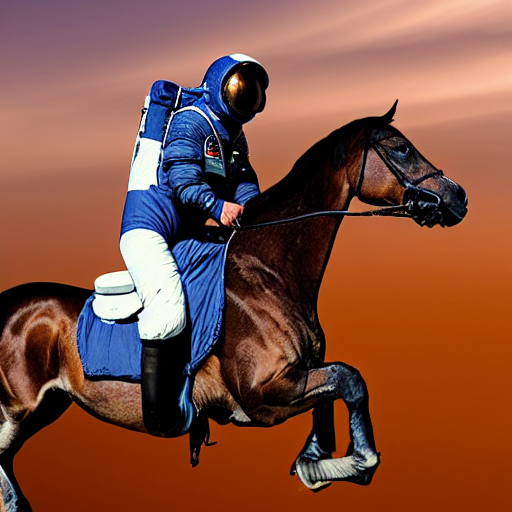

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Nice, as we can see the photo has quite a definition 🔥.